# Time Series Analysis of the Evolution of Brazilian Electric Energy between 2000 and 2020

## PROJECT DESCRIPTION

A country's energy capacity is vital for a country's economic growth. In a world with ever-increasing energy demand, each country will need to expand its energy matrix - especially electricity - on an ongoing basis. However, measures to contain Global Warming are increasing, trying to minimize the emission of polluting gases. In this way, the expansion of the electricity matrix of each country must use, preferably, renewable and low-polluting sources to guarantee a better world for the next generations.

Brazil is known worldwide for its great diversity and prevalence of natural resources, which allows its electrical matrix to have a substantial predominance of renewable sources. However, the growing energy demand has caused problems in guaranteeing the energy supply to the population, which may worsen in the future. Therefore, this work aims to evaluate the growth of Brazilian electricity between 2000 and 2020 based on energy data dispatched in the SIN (National Interconnected System).

This project has two main objectives:

- Exploratory Data Analysis (EDA) of the dataset, with a greater focus on Total Energy Dispatched from energy;
- Creation of a predictive model of the behavior of Total Energy using the SARIMA model.


## 1. IMPORTS

Below are the libraries imported for this project. Classes were created in separate ".py" files that group the functions made to realize the project. These files are attached with the project on [GitHub](https://github.com/LuanRD/energia-eletrica).

In [1]:
import pandas as pd

# Class with functions for Exploratory Data Analysis
from classes_eda import Charts, Correlation, Stats, Null

# Class with functions for creating the SARIMA model
from class_sarima import Sarima

## 2. DATA COLLECTION

The data used in this project was collected through the Open Data Portal provided by ANEEL - National Electric Energy Agency. The data comprise the history of the volume of electricity produced in Brazil dispatched in the National Interconnected System (SIN) between January 2000 and June 2020 (the most up-to-date data available as this dataset has been discontinued). The portal can be accessed through this [link](https://dados.gov.br/dataset/geracao-por-fonte1).

In [2]:
# Upload and read project data
df = pd.read_csv('GeracaoFonte.csv')
df.head()

,ideGeracaoFonte,nomFonteGeracao,mdaEnergiaDespachadaGWh,mesReferencia,anoReferencia,dthProcessamento
0,1,Hidreletricas exclusive Itaipu,21074.749841,1,2000,NaN
1,2,Itaipu,6523.780292,1,2000,NaN
2,3,Oleo Diesel / Combustivel,112.026593,1,2000,NaN
3,4,Gas Natural,512.536500,1,2000,NaN
4,5,Carvao,772.954908,1,2000,NaN


Below are the descriptions of each variable made available by ANEEL in its Data Dictionary, which can be accessed by [link](https://www.aneel.gov.br/documents/656835/15191504/DD_IG_1_3.pdf/f4be6c6e-4336-0f51-c6d3-f75d184e6e92). Each variable had its type specified.



| Variable | Type | Description|
|:------:|:------:|:------:|
| IdeGeracaoFonte | int64 | Identifier Generation Source|
| NomFonteGeracao| object | Electric power generation source name|
| MdaEnergiaDespachadaGWh| float64 | Amount of Energy Load dispatched by the interconnected system and isolated generators |
| MesReferencia| int64 | Reference month for the collection of dispatched energy load in GWh|
| AnoReferencia| int64 | Reference year for the collection of dispatched energy load in GWh|
| DthProcessamento| object | Date and time of autoloading processing.|

## 3. DATA WRANGLING

### 3.1. Preliminary Data Treatment 

Data processing is performed as a first measure before the analysis and application of Time Series models. It is essential to be very careful at this stage as data with inadequate treatment can generate incorrect analyzes and models, compromising any conclusions made.

In [3]:
# Sum of the null values of each variable
df.isna().sum()

ideGeracaoFonte               0
nomFonteGeracao               0
mdaEnergiaDespachadaGWh      71
mesReferencia                 0
anoReferencia                 0
dthProcessamento           2364
dtype: int64

Elimination of the column "dthProcessamento" due to the strong predominance of null values ​​and the column "ideGeracaoFonte" because the Pandas DataFrame already inserts indexes for each value.
Also, the posterior deletion of rows would make the values ​​provided by "ideGeracaoFonte" inconsistent with the state of the DataFrame.

In [4]:
# Deletion of selected columns
df.drop(['dthProcessamento', 'ideGeracaoFonte'], axis=1, inplace=True)
df

,nomFonteGeracao,mdaEnergiaDespachadaGWh,mesReferencia,anoReferencia
0,Hidreletricas exclusive Itaipu,21074.749841,1,2000
1,Itaipu,6523.780292,1,2000
2,Oleo Diesel / Combustivel,112.026593,1,2000
3,Gas Natural,512.536500,1,2000
4,Carvao,772.954908,1,2000
...,...,...,...,...
2491,Carvao,610.747200,6,2020
2492,Biomassas,1030.651200,6,2020
2493,Nuclear,1037.253600,6,2020
2494,Residuos Processos Industriais,765.554400,6,2020


Since the data has a behavior that varies with time, it is necessary to have a format that adapts the date variable to the one accepted by Pandas (year-month-day / 2000-01-01). Thus, the variable "day" was created, with "day 1" arbitrarily chosen since the data is available monthly.

In [5]:
# Replacement of column names with temporal data for "year" and "month"
df.rename(columns = {'mesReferencia': 'month', 'anoReferencia': 'year'}, inplace=True)

# Creation of the column "day"
day = pd.Series(1 for x in range(len(df)))
df['day'] = day.values

# Aggregation of data referring to the day and creation of the "date" column
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

# Index reset to adapt to the number of variables present in the dataframe
df = df.set_index('date', drop=True)
df.head(5)

,nomFonteGeracao,mdaEnergiaDespachadaGWh,month,year,day
date,,,,,
2000-01-01,Hidreletricas exclusive Itaipu,21074.749841,1,2000,1
2000-01-01,Itaipu,6523.780292,1,2000,1
2000-01-01,Oleo Diesel / Combustivel,112.026593,1,2000,1
2000-01-01,Gas Natural,512.536500,1,2000,1
2000-01-01,Carvao,772.954908,1,2000,1


To facilitate the analysis made in this notebook each Generation Source will be arranged in a column. First, the columns referring to the day, month, and year will be eliminated, since the data variable contains that information.

In [6]:
# Deletion of selected columns
df.drop(['day', 'month', 'year'], axis=1, inplace=True)
df

,nomFonteGeracao,mdaEnergiaDespachadaGWh
date,,
2000-01-01,Hidreletricas exclusive Itaipu,21074.749841
2000-01-01,Itaipu,6523.780292
2000-01-01,Oleo Diesel / Combustivel,112.026593
2000-01-01,Gas Natural,512.536500
2000-01-01,Carvao,772.954908
...,...,...
2020-06-01,Carvao,610.747200
2020-06-01,Biomassas,1030.651200
2020-06-01,Nuclear,1037.253600


Now the data will be pivoted so that it is rearranged as desired.

In [7]:
# Pivoting the rows to rearrange the DataFrame
df = df.pivot(columns='nomFonteGeracao', values='mdaEnergiaDespachadaGWh')
df

nomFonteGeracao,Biomassas,Carvao,Energia produzida fora do SIN,Eolicas,Gas Natural,Hidreletricas exclusive Itaipu,Itaipu,Nuclear,Oleo Diesel / Combustivel,Residuos Processos Industriais,Solar Fotovoltaica
date,,,,,,,,,,,
2000-01-01,0.00000,772.954908,NaN,0.00000,512.536500,21074.749841,6523.780292,418.609402,112.026593,0.00000,NaN
2000-02-01,0.00000,726.482505,NaN,0.00000,580.842549,20519.823366,6362.831799,400.617872,69.214905,0.00000,NaN
2000-03-01,0.00000,685.798458,20670.975,0.00000,513.065176,21184.922627,7593.289824,400.187101,78.197350,0.00000,NaN
2000-04-01,358.88560,0.000000,0.000,0.00000,675.601700,7128.300200,39.287100,0.000000,337.403200,0.00000,NaN
2000-05-01,0.00000,725.874700,NaN,0.00000,503.225500,21986.323500,6814.969400,0.000000,101.455500,0.00000,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01,309.88008,1000.854960,0.000,2710.30752,3349.402560,32612.889600,5646.801120,948.641040,46.534560,838.10232,357.36816
2020-03-01,451.83864,643.321920,0.000,2215.23768,2616.893520,35229.709440,5294.795040,1282.120320,84.220800,832.03008,419.48208
2020-04-01,759.34080,202.917600,0.000,3039.06240,2068.552800,28373.400000,3886.149600,1358.755200,124.992000,759.37680,438.44400


"Month" and "year" columns will be reinserted in the Dataframe while "date" is kept as an index.

In [8]:
# Index reset
df.reset_index(inplace=True, drop=False)

# Creation of 'month' and 'year' variables from 'date'
df['month'] = pd.DatetimeIndex(df['date']).month
df['year'] = pd.DatetimeIndex(df['date']).year

# Return 'date' as index
df = df.set_index('date', drop=False)

# Deletion of residual 'date' column
df.drop(['date'], axis=1, inplace=True)
df.head(5)

nomFonteGeracao,Biomassas,Carvao,Energia produzida fora do SIN,Eolicas,Gas Natural,Hidreletricas exclusive Itaipu,Itaipu,Nuclear,Oleo Diesel / Combustivel,Residuos Processos Industriais,Solar Fotovoltaica,month,year
date,,,,,,,,,,,,,
2000-01-01,0.0000,772.954908,NaN,0.0,512.536500,21074.749841,6523.780292,418.609402,112.026593,0.0,NaN,1,2000
2000-02-01,0.0000,726.482505,NaN,0.0,580.842549,20519.823366,6362.831799,400.617872,69.214905,0.0,NaN,2,2000
2000-03-01,0.0000,685.798458,20670.975,0.0,513.065176,21184.922627,7593.289824,400.187101,78.197350,0.0,NaN,3,2000
2000-04-01,358.8856,0.000000,0.000,0.0,675.601700,7128.300200,39.287100,0.000000,337.403200,0.0,NaN,4,2000
2000-05-01,0.0000,725.874700,NaN,0.0,503.225500,21986.323500,6814.969400,0.000000,101.455500,0.0,NaN,5,2000


The Generation Sources present in the DataFrame will be standardized to avoid problems when selecting a variable, normally caused by the presence of spaces and special characters. In addition, translations and simplifications were made in the names of some variables.

In [9]:
# Changes in columns names
df = df.rename(columns={
    'Biomassas': 'Biomass',
    'Carvao': 'Coal',
    'Energia produzida fora do SIN':'Out_of_SIN',
    'Eolicas': 'Wind',
    'Gas Natural': 'Natural_Gas',
    'Hidreletricas exclusive Itaipu': 'Hydro_except_Itaipu',
    'Oleo Diesel / Combustivel': 'Oil',
    'Residuos Processos Industriais': 'Industrial_Waste',
    'Solar Fotovoltaica': 'Solar_PV'
})
df

nomFonteGeracao,Biomass,Coal,Out_of_SIN,Wind,Natural_Gas,Hydro_except_Itaipu,Itaipu,Nuclear,Oil,Industrial_Waste,Solar_PV,month,year
date,,,,,,,,,,,,,
2000-01-01,0.00000,772.954908,NaN,0.00000,512.536500,21074.749841,6523.780292,418.609402,112.026593,0.00000,NaN,1,2000
2000-02-01,0.00000,726.482505,NaN,0.00000,580.842549,20519.823366,6362.831799,400.617872,69.214905,0.00000,NaN,2,2000
2000-03-01,0.00000,685.798458,20670.975,0.00000,513.065176,21184.922627,7593.289824,400.187101,78.197350,0.00000,NaN,3,2000
2000-04-01,358.88560,0.000000,0.000,0.00000,675.601700,7128.300200,39.287100,0.000000,337.403200,0.00000,NaN,4,2000
2000-05-01,0.00000,725.874700,NaN,0.00000,503.225500,21986.323500,6814.969400,0.000000,101.455500,0.00000,NaN,5,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01,309.88008,1000.854960,0.000,2710.30752,3349.402560,32612.889600,5646.801120,948.641040,46.534560,838.10232,357.36816,2,2020
2020-03-01,451.83864,643.321920,0.000,2215.23768,2616.893520,35229.709440,5294.795040,1282.120320,84.220800,832.03008,419.48208,3,2020
2020-04-01,759.34080,202.917600,0.000,3039.06240,2068.552800,28373.400000,3886.149600,1358.755200,124.992000,759.37680,438.44400,4,2020


For the analysis of the Brazilian Electricity Matrix, the creation of some variables will deepen the analysis. In this way, some groupings will be made so that they are added to the DataFrame.

First, a column will be created with the total values ​​of Energy Generated on each date.

In [10]:
# Creation of the variable "total"
total = df.sum(axis=1) - df['month'] - df['year']

# Adding the variable to the DataFrame
df = df.assign(Total=total)
df

nomFonteGeracao,Biomass,Coal,Out_of_SIN,Wind,Natural_Gas,Hydro_except_Itaipu,Itaipu,Nuclear,Oil,Industrial_Waste,Solar_PV,month,year,Total
date,,,,,,,,,,,,,,
2000-01-01,0.00000,772.954908,NaN,0.00000,512.536500,21074.749841,6523.780292,418.609402,112.026593,0.00000,NaN,1,2000,29414.657538
2000-02-01,0.00000,726.482505,NaN,0.00000,580.842549,20519.823366,6362.831799,400.617872,69.214905,0.00000,NaN,2,2000,28659.812997
2000-03-01,0.00000,685.798458,20670.975,0.00000,513.065176,21184.922627,7593.289824,400.187101,78.197350,0.00000,NaN,3,2000,51126.435535
2000-04-01,358.88560,0.000000,0.000,0.00000,675.601700,7128.300200,39.287100,0.000000,337.403200,0.00000,NaN,4,2000,8539.477800
2000-05-01,0.00000,725.874700,NaN,0.00000,503.225500,21986.323500,6814.969400,0.000000,101.455500,0.00000,NaN,5,2000,30131.848600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01,309.88008,1000.854960,0.000,2710.30752,3349.402560,32612.889600,5646.801120,948.641040,46.534560,838.10232,357.36816,2,2020,47820.781920
2020-03-01,451.83864,643.321920,0.000,2215.23768,2616.893520,35229.709440,5294.795040,1282.120320,84.220800,832.03008,419.48208,3,2020,49069.649520
2020-04-01,759.34080,202.917600,0.000,3039.06240,2068.552800,28373.400000,3886.149600,1358.755200,124.992000,759.37680,438.44400,4,2020,41010.991200


Creation of variables referring to 
"Renewable" and "Non-Renewable" Sources, excluding "Out_of_SIN" and "Residuos_Industriais" from these classifications.

In [11]:
# Renewable Sources selection
list_renewable = ['Hydro_except_Itaipu', 'Itaipu', 'Wind', 'Biomass', 'Solar_PV']
renewable_selection = df[list_renewable]

# Creation of the Renewable Sources grouping 
renewable = renewable_selection.sum(axis=1)

# Insering the grouping into the DataFrame
df = df.assign(Renewable=renewable)

df

nomFonteGeracao,Biomass,Coal,Out_of_SIN,Wind,Natural_Gas,Hydro_except_Itaipu,Itaipu,Nuclear,Oil,Industrial_Waste,Solar_PV,month,year,Total,Renewable
date,,,,,,,,,,,,,,,
2000-01-01,0.00000,772.954908,NaN,0.00000,512.536500,21074.749841,6523.780292,418.609402,112.026593,0.00000,NaN,1,2000,29414.657538,27598.530133
2000-02-01,0.00000,726.482505,NaN,0.00000,580.842549,20519.823366,6362.831799,400.617872,69.214905,0.00000,NaN,2,2000,28659.812997,26882.655166
2000-03-01,0.00000,685.798458,20670.975,0.00000,513.065176,21184.922627,7593.289824,400.187101,78.197350,0.00000,NaN,3,2000,51126.435535,28778.212451
2000-04-01,358.88560,0.000000,0.000,0.00000,675.601700,7128.300200,39.287100,0.000000,337.403200,0.00000,NaN,4,2000,8539.477800,7526.472900
2000-05-01,0.00000,725.874700,NaN,0.00000,503.225500,21986.323500,6814.969400,0.000000,101.455500,0.00000,NaN,5,2000,30131.848600,28801.292900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01,309.88008,1000.854960,0.000,2710.30752,3349.402560,32612.889600,5646.801120,948.641040,46.534560,838.10232,357.36816,2,2020,47820.781920,41637.246480
2020-03-01,451.83864,643.321920,0.000,2215.23768,2616.893520,35229.709440,5294.795040,1282.120320,84.220800,832.03008,419.48208,3,2020,49069.649520,43611.062880
2020-04-01,759.34080,202.917600,0.000,3039.06240,2068.552800,28373.400000,3886.149600,1358.755200,124.992000,759.37680,438.44400,4,2020,41010.991200,36496.396800


In [12]:
# Non-Renewable Sources selection
list_non_renewable = ['Oil', 'Natural_Gas', 'Coal', 'Nuclear']
non_renewable_selection = df[list_non_renewable]

# Creation of the Non-Renewable Sources grouping
non_renewable = non_renewable_selection.sum(axis=1)

# Insering the grouping into the DataFrame
df = df.assign(Non_Renewable=non_renewable)

df

nomFonteGeracao,Biomass,Coal,Out_of_SIN,Wind,Natural_Gas,Hydro_except_Itaipu,Itaipu,Nuclear,Oil,Industrial_Waste,Solar_PV,month,year,Total,Renewable,Non_Renewable
date,,,,,,,,,,,,,,,,
2000-01-01,0.00000,772.954908,NaN,0.00000,512.536500,21074.749841,6523.780292,418.609402,112.026593,0.00000,NaN,1,2000,29414.657538,27598.530133,1816.127404
2000-02-01,0.00000,726.482505,NaN,0.00000,580.842549,20519.823366,6362.831799,400.617872,69.214905,0.00000,NaN,2,2000,28659.812997,26882.655166,1777.157832
2000-03-01,0.00000,685.798458,20670.975,0.00000,513.065176,21184.922627,7593.289824,400.187101,78.197350,0.00000,NaN,3,2000,51126.435535,28778.212451,1677.248084
2000-04-01,358.88560,0.000000,0.000,0.00000,675.601700,7128.300200,39.287100,0.000000,337.403200,0.00000,NaN,4,2000,8539.477800,7526.472900,1013.004900
2000-05-01,0.00000,725.874700,NaN,0.00000,503.225500,21986.323500,6814.969400,0.000000,101.455500,0.00000,NaN,5,2000,30131.848600,28801.292900,1330.555700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01,309.88008,1000.854960,0.000,2710.30752,3349.402560,32612.889600,5646.801120,948.641040,46.534560,838.10232,357.36816,2,2020,47820.781920,41637.246480,5345.433120
2020-03-01,451.83864,643.321920,0.000,2215.23768,2616.893520,35229.709440,5294.795040,1282.120320,84.220800,832.03008,419.48208,3,2020,49069.649520,43611.062880,4626.556560
2020-04-01,759.34080,202.917600,0.000,3039.06240,2068.552800,28373.400000,3886.149600,1358.755200,124.992000,759.37680,438.44400,4,2020,41010.991200,36496.396800,3755.217600


Brazil has historically had hydroelectric plants as its primary source of electricity. Thus, it is relevant to analyze this source especially - comparing it with the other sources in our matrix - and see how it evolved in this century.

In [13]:
# Creation of the Hydroeletric variable
hydro = df.Hydro_except_Itaipu + df.Itaipu

# Creation of the variable referring to the sum of other Energy Sources
others = total - hydro
others

date
2000-01-01     1816.127404
2000-02-01     1777.157832
2000-03-01    22348.223084
2000-04-01     1371.890500
2000-05-01     1330.555700
                  ...     
2020-02-01     9561.091200
2020-03-01     8545.145040
2020-04-01     8751.441600
2020-05-01     9960.954720
2020-06-01    11038.305600
Length: 246, dtype: float64

In addition to these variables, it is interesting to analyze the predominance of hydroelectric plants among Renewable Sources.

In [14]:
# Creation of the variable that sums the Renewable Sources except for the Hydroelectric Power Plants
other_renewable = renewable - hydro
other_renewable

date
2000-01-01       0.00000
2000-02-01       0.00000
2000-03-01       0.00000
2000-04-01     358.88560
2000-05-01       0.00000
                 ...    
2020-02-01    3377.55576
2020-03-01    3086.55840
2020-04-01    4236.84720
2020-05-01    5179.64616
2020-06-01    6196.65120
Length: 246, dtype: float64

In [15]:
# Assigning the variables to the Dataframe
df = df.assign(Hydro=hydro, Total_except_Hydro=others, Renewable_except_Hydro=other_renewable)
df

nomFonteGeracao,Biomass,Coal,Out_of_SIN,Wind,Natural_Gas,Hydro_except_Itaipu,Itaipu,Nuclear,Oil,Industrial_Waste,Solar_PV,month,year,Total,Renewable,Non_Renewable,Hydro,Total_except_Hydro,Renewable_except_Hydro
date,,,,,,,,,,,,,,,,,,,
2000-01-01,0.00000,772.954908,NaN,0.00000,512.536500,21074.749841,6523.780292,418.609402,112.026593,0.00000,NaN,1,2000,29414.657538,27598.530133,1816.127404,27598.530133,1816.127404,0.00000
2000-02-01,0.00000,726.482505,NaN,0.00000,580.842549,20519.823366,6362.831799,400.617872,69.214905,0.00000,NaN,2,2000,28659.812997,26882.655166,1777.157832,26882.655166,1777.157832,0.00000
2000-03-01,0.00000,685.798458,20670.975,0.00000,513.065176,21184.922627,7593.289824,400.187101,78.197350,0.00000,NaN,3,2000,51126.435535,28778.212451,1677.248084,28778.212451,22348.223084,0.00000
2000-04-01,358.88560,0.000000,0.000,0.00000,675.601700,7128.300200,39.287100,0.000000,337.403200,0.00000,NaN,4,2000,8539.477800,7526.472900,1013.004900,7167.587300,1371.890500,358.88560
2000-05-01,0.00000,725.874700,NaN,0.00000,503.225500,21986.323500,6814.969400,0.000000,101.455500,0.00000,NaN,5,2000,30131.848600,28801.292900,1330.555700,28801.292900,1330.555700,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01,309.88008,1000.854960,0.000,2710.30752,3349.402560,32612.889600,5646.801120,948.641040,46.534560,838.10232,357.36816,2,2020,47820.781920,41637.246480,5345.433120,38259.690720,9561.091200,3377.55576
2020-03-01,451.83864,643.321920,0.000,2215.23768,2616.893520,35229.709440,5294.795040,1282.120320,84.220800,832.03008,419.48208,3,2020,49069.649520,43611.062880,4626.556560,40524.504480,8545.145040,3086.55840
2020-04-01,759.34080,202.917600,0.000,3039.06240,2068.552800,28373.400000,3886.149600,1358.755200,124.992000,759.37680,438.44400,4,2020,41010.991200,36496.396800,3755.217600,32259.549600,8751.441600,4236.84720


With the insertion of new columns, the DataFrame needs to have its columns reorganized so that it is easier to identify similar groups.

In [16]:
# Estabilished order
order = ['Coal', 'Natural_Gas', 'Nuclear', 'Oil', 'Hydro_except_Itaipu', 
        'Itaipu', 'Biomass', 'Wind', 'Solar_PV', 'Out_of_SIN', 
        'Industrial_Waste', 'Renewable', 'Non_Renewable', 'Hydro', 
        'Renewable_except_Hydro', 'Total_except_Hydro', 'Total', 'month', 'year']

In [17]:
# Organized data
df = df[order]
df

nomFonteGeracao,Coal,Natural_Gas,Nuclear,Oil,Hydro_except_Itaipu,Itaipu,Biomass,Wind,Solar_PV,Out_of_SIN,Industrial_Waste,Renewable,Non_Renewable,Hydro,Renewable_except_Hydro,Total_except_Hydro,Total,month,year
date,,,,,,,,,,,,,,,,,,,
2000-01-01,772.954908,512.536500,418.609402,112.026593,21074.749841,6523.780292,0.00000,0.00000,NaN,NaN,0.00000,27598.530133,1816.127404,27598.530133,0.00000,1816.127404,29414.657538,1,2000
2000-02-01,726.482505,580.842549,400.617872,69.214905,20519.823366,6362.831799,0.00000,0.00000,NaN,NaN,0.00000,26882.655166,1777.157832,26882.655166,0.00000,1777.157832,28659.812997,2,2000
2000-03-01,685.798458,513.065176,400.187101,78.197350,21184.922627,7593.289824,0.00000,0.00000,NaN,20670.975,0.00000,28778.212451,1677.248084,28778.212451,0.00000,22348.223084,51126.435535,3,2000
2000-04-01,0.000000,675.601700,0.000000,337.403200,7128.300200,39.287100,358.88560,0.00000,NaN,0.000,0.00000,7526.472900,1013.004900,7167.587300,358.88560,1371.890500,8539.477800,4,2000
2000-05-01,725.874700,503.225500,0.000000,101.455500,21986.323500,6814.969400,0.00000,0.00000,NaN,NaN,0.00000,28801.292900,1330.555700,28801.292900,0.00000,1330.555700,30131.848600,5,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01,1000.854960,3349.402560,948.641040,46.534560,32612.889600,5646.801120,309.88008,2710.30752,357.36816,0.000,838.10232,41637.246480,5345.433120,38259.690720,3377.55576,9561.091200,47820.781920,2,2020
2020-03-01,643.321920,2616.893520,1282.120320,84.220800,35229.709440,5294.795040,451.83864,2215.23768,419.48208,0.000,832.03008,43611.062880,4626.556560,40524.504480,3086.55840,8545.145040,49069.649520,3,2020
2020-04-01,202.917600,2068.552800,1358.755200,124.992000,28373.400000,3886.149600,759.34080,3039.06240,438.44400,0.000,759.37680,36496.396800,3755.217600,32259.549600,4236.84720,8751.441600,41010.991200,4,2020


In [18]:
# Data Information
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 246 entries, 2000-01-01 to 2020-06-01
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Coal                    246 non-null    float64
 1   Natural_Gas             246 non-null    float64
 2   Nuclear                 246 non-null    float64
 3   Oil                     246 non-null    float64
 4   Hydro_except_Itaipu     246 non-null    float64
 5   Itaipu                  246 non-null    float64
 6   Biomass                 246 non-null    float64
 7   Wind                    246 non-null    float64
 8   Solar_PV                36 non-null     float64
 9   Out_of_SIN              175 non-null    float64
 10  Industrial_Waste        246 non-null    float64
 11  Renewable               246 non-null    float64
 12  Non_Renewable           246 non-null    float64
 13  Hydro                   246 non-null    float64
 14  Renewable_except_Hydro 

The information above shows the main information of the DataFrame, which has 246 entries arranged in 19 columns, in addition to the fact that all variables - except index (date), 'month' and 'year' (int) - are of type float (floating value number).

However, the presence of null values ​​in columns 8 and 9 is noted, since their count of non-null values ​​is not equal to the number of entries. In this way, the treatment of these values ​​will be done by replacing them with 0.

In [19]:
# Filling null values with 0
df = df.fillna(0)
df

nomFonteGeracao,Coal,Natural_Gas,Nuclear,Oil,Hydro_except_Itaipu,Itaipu,Biomass,Wind,Solar_PV,Out_of_SIN,Industrial_Waste,Renewable,Non_Renewable,Hydro,Renewable_except_Hydro,Total_except_Hydro,Total,month,year
date,,,,,,,,,,,,,,,,,,,
2000-01-01,772.954908,512.536500,418.609402,112.026593,21074.749841,6523.780292,0.00000,0.00000,0.00000,0.000,0.00000,27598.530133,1816.127404,27598.530133,0.00000,1816.127404,29414.657538,1,2000
2000-02-01,726.482505,580.842549,400.617872,69.214905,20519.823366,6362.831799,0.00000,0.00000,0.00000,0.000,0.00000,26882.655166,1777.157832,26882.655166,0.00000,1777.157832,28659.812997,2,2000
2000-03-01,685.798458,513.065176,400.187101,78.197350,21184.922627,7593.289824,0.00000,0.00000,0.00000,20670.975,0.00000,28778.212451,1677.248084,28778.212451,0.00000,22348.223084,51126.435535,3,2000
2000-04-01,0.000000,675.601700,0.000000,337.403200,7128.300200,39.287100,358.88560,0.00000,0.00000,0.000,0.00000,7526.472900,1013.004900,7167.587300,358.88560,1371.890500,8539.477800,4,2000
2000-05-01,725.874700,503.225500,0.000000,101.455500,21986.323500,6814.969400,0.00000,0.00000,0.00000,0.000,0.00000,28801.292900,1330.555700,28801.292900,0.00000,1330.555700,30131.848600,5,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01,1000.854960,3349.402560,948.641040,46.534560,32612.889600,5646.801120,309.88008,2710.30752,357.36816,0.000,838.10232,41637.246480,5345.433120,38259.690720,3377.55576,9561.091200,47820.781920,2,2020
2020-03-01,643.321920,2616.893520,1282.120320,84.220800,35229.709440,5294.795040,451.83864,2215.23768,419.48208,0.000,832.03008,43611.062880,4626.556560,40524.504480,3086.55840,8545.145040,49069.649520,3,2020
2020-04-01,202.917600,2068.552800,1358.755200,124.992000,28373.400000,3886.149600,759.34080,3039.06240,438.44400,0.000,759.37680,36496.396800,3755.217600,32259.549600,4236.84720,8751.441600,41010.991200,4,2020


### 3.2. Data Cleaning

For the data to be analyzed, any incorrect data must be treated a priori. To illustrate the problem in this dataset, a line graph will be plotted to follow the evolution of the Brazilian Electricity Matrix without distinction by type of source.

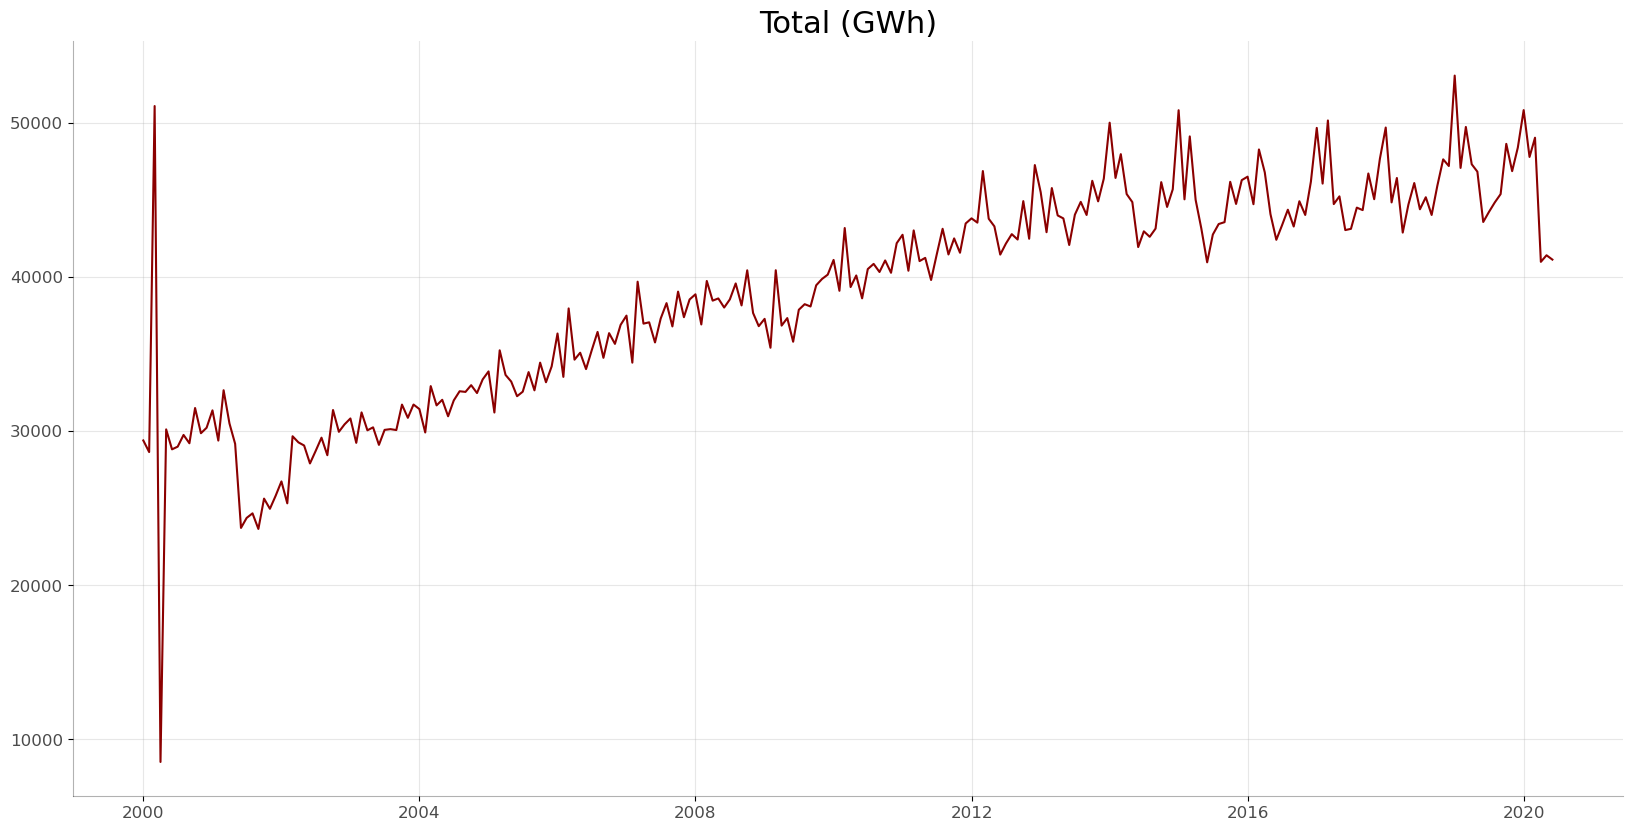

In [20]:
# Creation of the object referring to the "Charts" Class of Total Energy (sum and sum_perc have not yet been defined)
total_chart = Charts('Total', df, sum=None, sum_perc=None)

# Line chart for Total Energy data
total_chart.lineplot()

Analyzing the line graph, it is noticeable a temporal growth and the presence of seasonality. However, the oscillation at the beginning of the series is very discrepant compared to the other data. Now, the boxplot of this dataset will be analyzed.

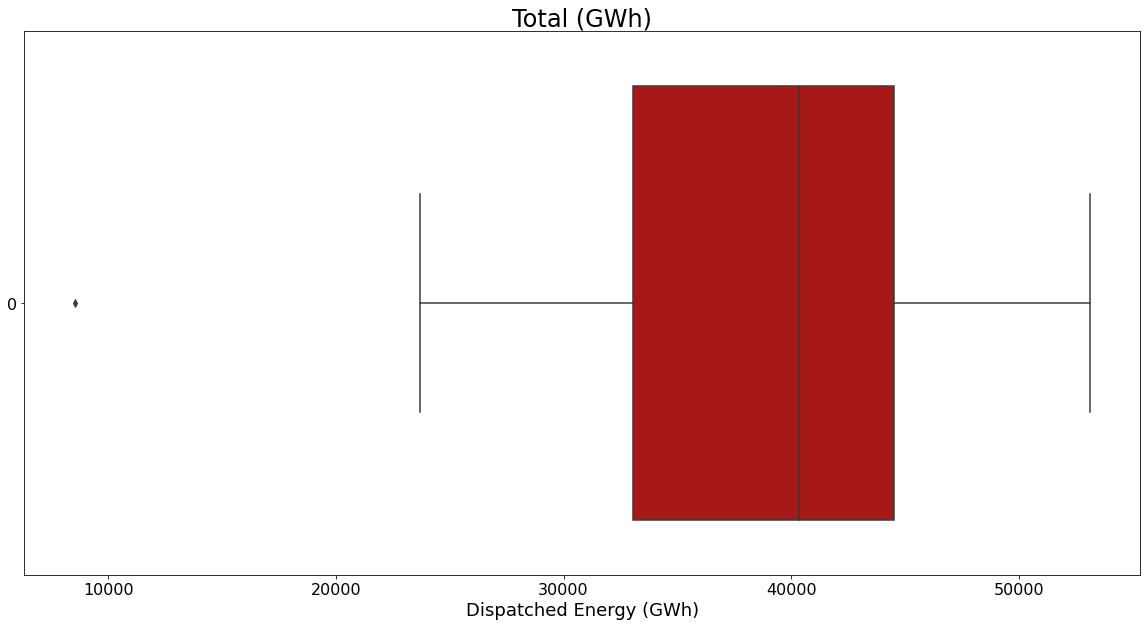

In [21]:
# Boxplot for Total Energy data
total_chart.boxplot()

It is noticeable the presence of an outlier in the boxplot. Therefore, it is interesting to identify the exact period in which this unexpected value occurs and plot this data. As the large discrepancy occurs at the beginning of the data set, the first 10 months will be analyzed.

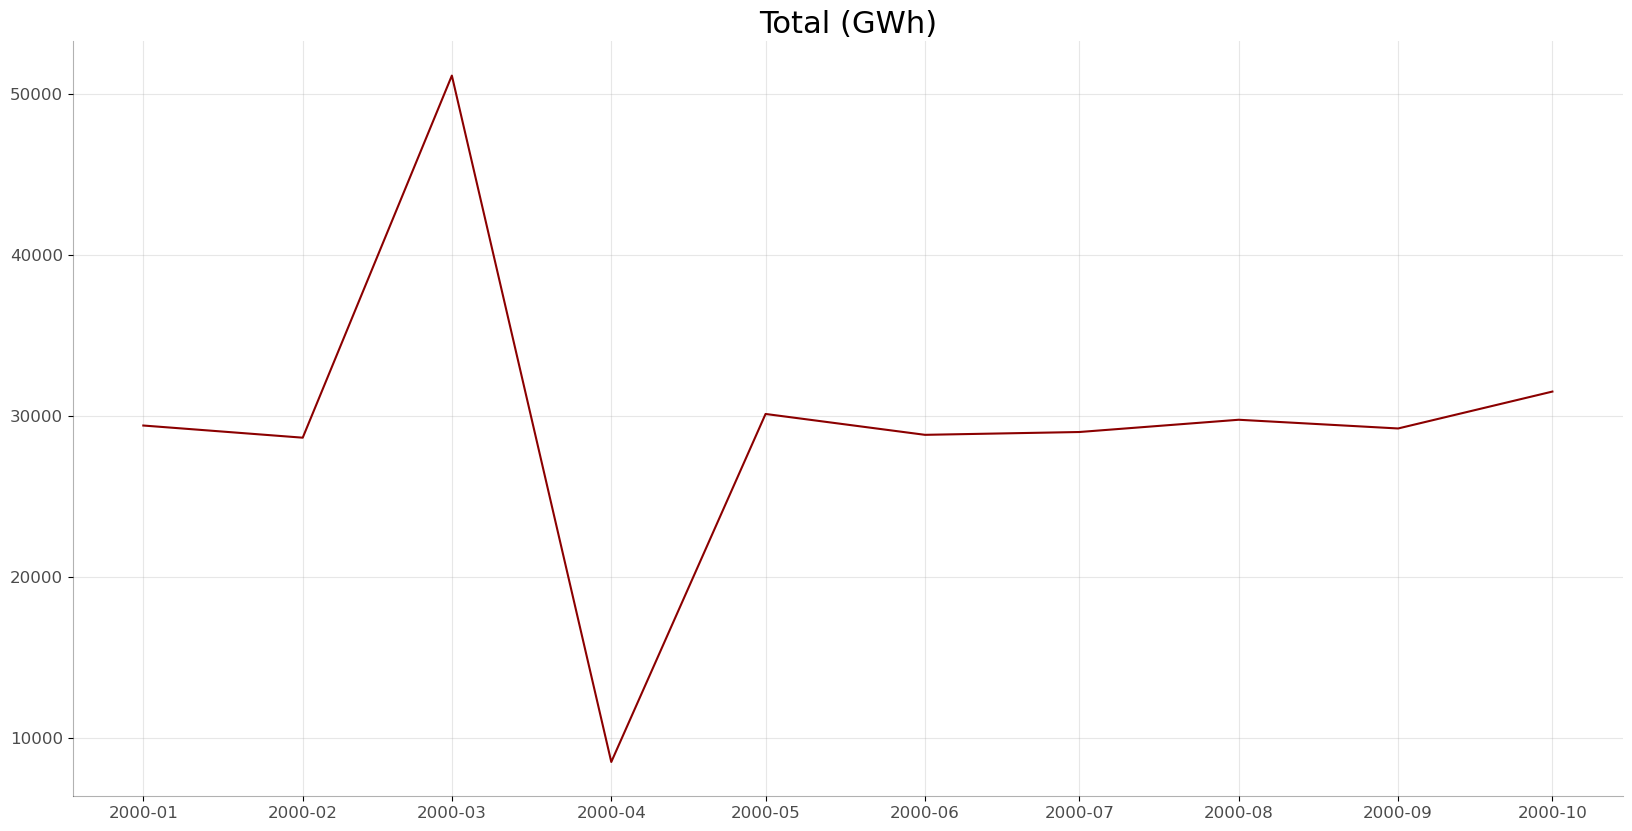

In [22]:
# Creation of the object referring to the "Charts" Class of Total Energy (sum and sum_perc have yet to be defined)
total_chart = Charts('Total', df[:10], sum=None, sum_perc=None)

# Line chart for the first 10 data
total_chart.lineplot()

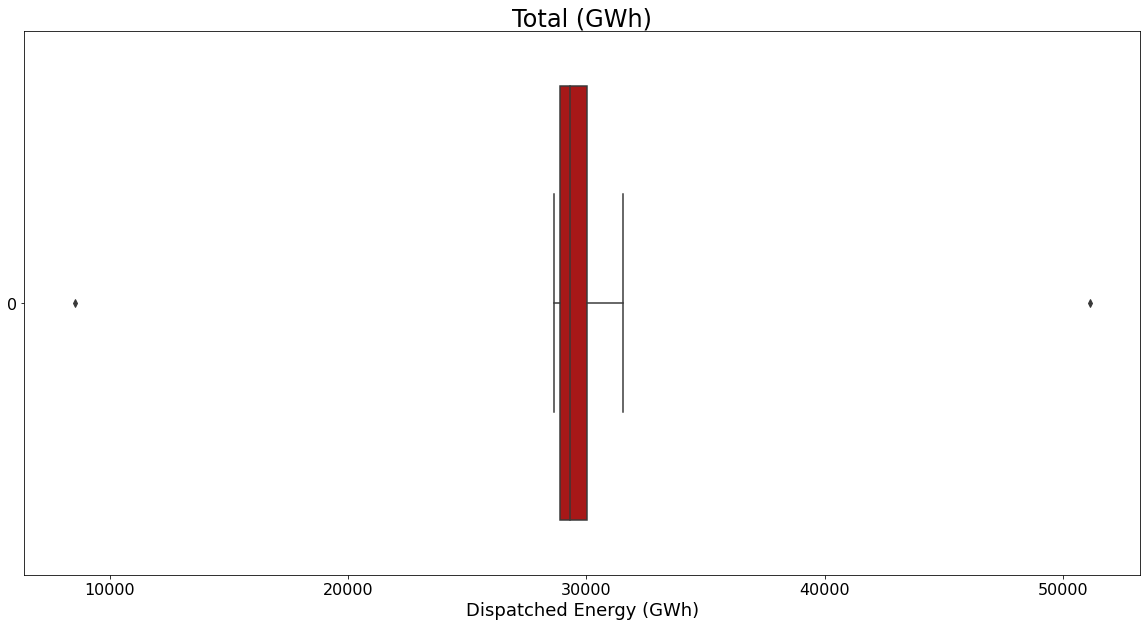

In [23]:
# Boxplot for the first 10 data
total_chart.boxplot()

In [24]:
# Creation of the object referring to the "Charts" Class of Total Energy (sum and sum_perc have yet to be defined)
total_stats = Stats('Total', df[:10])
# Obtaining outliers values
total_stats.get_outliers()

(                Total
 date                 
 2000-04-01  8539.4778,
                    Total
 date                    
 2000-03-01  51126.435535)

The graphs above show in greater detail the great variation in the Total Dispatched Energy data in these months with a return to the Feb/2000 trend from May/2000, in addition to the presence of two very discrepant data (Mar/2000 and Apr/2000 ). Below is a more detailed sample of the data, evaluating Dispatched Energy data by Energy Source.

In [25]:
# Visualization in DataFrame of the first 10 data
df.head(10)

nomFonteGeracao,Coal,Natural_Gas,Nuclear,Oil,Hydro_except_Itaipu,Itaipu,Biomass,Wind,Solar_PV,Out_of_SIN,Industrial_Waste,Renewable,Non_Renewable,Hydro,Renewable_except_Hydro,Total_except_Hydro,Total,month,year
date,,,,,,,,,,,,,,,,,,,
2000-01-01,772.954908,512.536500,418.609402,112.026593,21074.749841,6523.780292,0.0000,0.0,0.0,0.000,0.0,27598.530133,1816.127404,27598.530133,0.0000,1816.127404,29414.657538,1,2000
2000-02-01,726.482505,580.842549,400.617872,69.214905,20519.823366,6362.831799,0.0000,0.0,0.0,0.000,0.0,26882.655166,1777.157832,26882.655166,0.0000,1777.157832,28659.812997,2,2000
2000-03-01,685.798458,513.065176,400.187101,78.197350,21184.922627,7593.289824,0.0000,0.0,0.0,20670.975,0.0,28778.212451,1677.248084,28778.212451,0.0000,22348.223084,51126.435535,3,2000
2000-04-01,0.000000,675.601700,0.000000,337.403200,7128.300200,39.287100,358.8856,0.0,0.0,0.000,0.0,7526.472900,1013.004900,7167.587300,358.8856,1371.890500,8539.477800,4,2000
2000-05-01,725.874700,503.225500,0.000000,101.455500,21986.323500,6814.969400,0.0000,0.0,0.0,0.000,0.0,28801.292900,1330.555700,28801.292900,0.0000,1330.555700,30131.848600,5,2000
2000-06-01,725.001500,574.331600,0.011100,105.998400,20503.398688,6928.030200,0.0000,0.0,0.0,0.000,0.0,27431.428888,1405.342600,27431.428888,0.0000,1405.342600,28836.771488,6,2000
2000-07-01,607.471400,540.092500,67.880700,130.207000,20243.011430,7423.097700,0.0000,0.0,0.0,0.000,0.0,27666.109130,1345.651600,27666.109130,0.0000,1345.651600,29011.760730,7,2000
2000-08-01,627.496300,547.118200,672.390800,127.627800,20366.155900,7431.322900,0.0000,0.0,0.0,0.000,0.0,27797.478800,1974.633100,27797.478800,0.0000,1974.633100,29772.111900,8,2000
2000-09-01,397.343100,500.284800,781.171600,80.348230,19379.092090,8093.236840,0.0000,0.0,0.0,0.000,0.0,27472.328930,1759.147730,27472.328930,0.0000,1759.147730,29231.476660,9,2000


The insertion of an Energy value in the variable "Fora_do_SIN" in April/2000 can be seen as inappropriate, generating an abnormally high value for March and substantially low values ​​for some variables in April, with May having more coherent values ​​for some variables.

In [26]:
# Visualization in DataFrame of the data of the variable 'Out_of_SIN' with values greater than zero
pd.DataFrame(df.query('Out_of_SIN > 0').Out_of_SIN)

,Out_of_SIN
date,
2000-03-01,20670.975000
2006-01-01,827.525252
2006-02-01,762.634875
2006-03-01,893.805701
2006-04-01,813.811430
...,...
2019-02-01,220.000000
2019-03-01,258.000000
2019-04-01,250.000000


The error deduced above is evident by noting that the values ​​of "Outside_do_SIN" are only re-computed in January 2006.

In [27]:
# Data selection between March and August of 2000 
df[2:8]

nomFonteGeracao,Coal,Natural_Gas,Nuclear,Oil,Hydro_except_Itaipu,Itaipu,Biomass,Wind,Solar_PV,Out_of_SIN,Industrial_Waste,Renewable,Non_Renewable,Hydro,Renewable_except_Hydro,Total_except_Hydro,Total,month,year
date,,,,,,,,,,,,,,,,,,,
2000-03-01,685.798458,513.065176,400.187101,78.19735,21184.922627,7593.289824,0.0000,0.0,0.0,20670.975,0.0,28778.212451,1677.248084,28778.212451,0.0000,22348.223084,51126.435535,3,2000
2000-04-01,0.000000,675.601700,0.000000,337.40320,7128.300200,39.287100,358.8856,0.0,0.0,0.000,0.0,7526.472900,1013.004900,7167.587300,358.8856,1371.890500,8539.477800,4,2000
2000-05-01,725.874700,503.225500,0.000000,101.45550,21986.323500,6814.969400,0.0000,0.0,0.0,0.000,0.0,28801.292900,1330.555700,28801.292900,0.0000,1330.555700,30131.848600,5,2000
2000-06-01,725.001500,574.331600,0.011100,105.99840,20503.398688,6928.030200,0.0000,0.0,0.0,0.000,0.0,27431.428888,1405.342600,27431.428888,0.0000,1405.342600,28836.771488,6,2000
2000-07-01,607.471400,540.092500,67.880700,130.20700,20243.011430,7423.097700,0.0000,0.0,0.0,0.000,0.0,27666.109130,1345.651600,27666.109130,0.0000,1345.651600,29011.760730,7,2000
2000-08-01,627.496300,547.118200,672.390800,127.62780,20366.155900,7431.322900,0.0000,0.0,0.0,0.000,0.0,27797.478800,1974.633100,27797.478800,0.0000,1974.633100,29772.111900,8,2000


Furthermore, a more in-depth analysis of the data from this period shows that the Nuclear Source does not have values ​​computed in April and May, only having values ​​similar to the previous ones in August 2000.  As this is the last variable to have a substantial unexplained discrepancy in the data, it is convenient to consider data from August 2000 onwards, creating a new variable to compute the data.

In [28]:
# Creation of the new variable "df_clean"
df_clean = df[7:]
df_clean

nomFonteGeracao,Coal,Natural_Gas,Nuclear,Oil,Hydro_except_Itaipu,Itaipu,Biomass,Wind,Solar_PV,Out_of_SIN,Industrial_Waste,Renewable,Non_Renewable,Hydro,Renewable_except_Hydro,Total_except_Hydro,Total,month,year
date,,,,,,,,,,,,,,,,,,,
2000-08-01,627.496300,547.118200,672.390800,127.627800,20366.15590,7431.322900,0.00000,0.00000,0.00000,0.0,0.00000,27797.478800,1974.633100,27797.478800,0.00000,1974.633100,29772.111900,8,2000
2000-09-01,397.343100,500.284800,781.171600,80.348230,19379.09209,8093.236840,0.00000,0.00000,0.00000,0.0,0.00000,27472.328930,1759.147730,27472.328930,0.00000,1759.147730,29231.476660,9,2000
2000-10-01,337.300572,551.155034,537.460912,70.415993,22529.27722,7495.719297,0.00000,0.00000,0.00000,0.0,0.00000,30024.996517,1496.332511,30024.996517,0.00000,1496.332511,31521.329028,10,2000
2000-11-01,489.986000,548.470000,1121.170800,100.395000,20175.47379,7448.224300,0.00000,0.00000,0.00000,0.0,0.00000,27623.698090,2260.021800,27623.698090,0.00000,2260.021800,29883.719890,11,2000
2000-12-01,640.149800,673.443400,1221.245700,94.221500,19822.51809,7787.367770,0.00000,0.00000,0.00000,0.0,0.00000,27609.885860,2629.060400,27609.885860,0.00000,2629.060400,30238.946260,12,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01,1000.854960,3349.402560,948.641040,46.534560,32612.88960,5646.801120,309.88008,2710.30752,357.36816,0.0,838.10232,41637.246480,5345.433120,38259.690720,3377.55576,9561.091200,47820.781920,2,2020
2020-03-01,643.321920,2616.893520,1282.120320,84.220800,35229.70944,5294.795040,451.83864,2215.23768,419.48208,0.0,832.03008,43611.062880,4626.556560,40524.504480,3086.55840,8545.145040,49069.649520,3,2020
2020-04-01,202.917600,2068.552800,1358.755200,124.992000,28373.40000,3886.149600,759.34080,3039.06240,438.44400,0.0,759.37680,36496.396800,3755.217600,32259.549600,4236.84720,8751.441600,41010.991200,4,2020


This demonstrates the difficulty of dealing with real-world data. They can often be miscalculated, which is evident when the discrepancy is very easy to notice. However, many errors can be more subtle and go unnoticed. Furthermore, changes in government policies, the insertion of a new source in the energy matrix, or some difficulty in supplying inputs can generate deviations from the previously observed patterns. Returning to the initial sentence, dealing with real-world data is complicated and requires analytical skills, subject knowledge, and thoroughness.

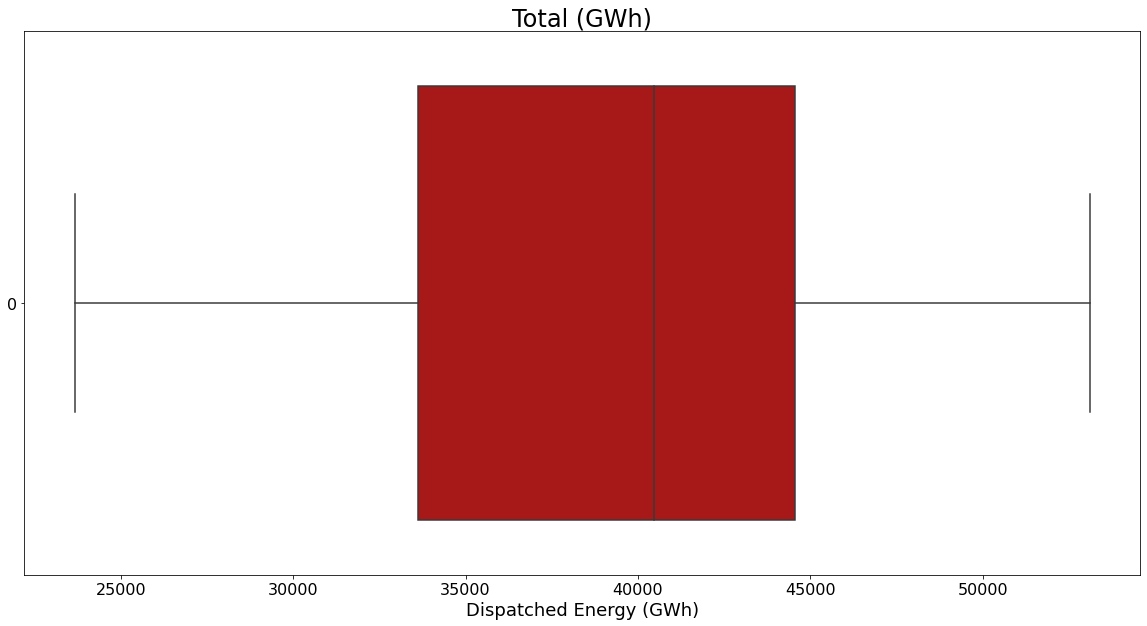

In [29]:
# Update of the object referring to the "Charts" Class of Total Energy (sum and sum_perc have yet to be defined)
total_chart = Charts('Total', df_clean, sum=None, sum_perc=None)

# Boxplot of total data after cleaning
total_chart.boxplot()

Now the Total Energy data appear to have an adequate behavior, which encourages a deeper analysis and the inference of trends of the observed phenomena. Thus, these will be the data used for the rest of the notebook.

### 3.3. Creating Auxiliary DataFrames

It is interesting to group the variables by year. In this way, the sum of the consolidated data for each year can be compared individually. Therefore, two Auxiliary DataFrames will be created to evaluate the sum of the values ​​of each variable between 2001 and 2019 (since these are the total values ​​available) and measure the annual percentage change in dispatched energy.

In [30]:
# Creation of the DataFrame with the summed values for the respective years
sum = df_clean.drop(columns='month')
sum = sum.groupby('year').sum()[1:20]
sum = sum.reset_index()
day = pd.Series(31 for x in range(len(sum)))
sum['day'] = day.values
month = pd.Series(12 for x in range(len(sum)))
sum['month'] = month.values

sum['date'] = pd.to_datetime(sum[['year', 'month', 'day']])

sum = sum.set_index('date', drop=True)
sum = sum.drop(columns = ['day', 'month', 'year'])

# Creation of the DataFrame with the percentual variation for the respective years
sum_perc = sum.pct_change()*100

# Filling null values with 0
sum_perc=sum_perc.fillna(0)

# Renaming the columns in the DataFrame with the percentage data
for i in range(len(sum.columns)):
    sum_perc = sum_perc.rename(columns = {sum_perc.columns[i]: f'{sum_perc.columns[i]}_perc'})

In [31]:
# Information regarding the Auxiliary DataFrame "sum"
sum.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19 entries, 2001-12-31 to 2019-12-31
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Coal                    19 non-null     float64
 1   Natural_Gas             19 non-null     float64
 2   Nuclear                 19 non-null     float64
 3   Oil                     19 non-null     float64
 4   Hydro_except_Itaipu     19 non-null     float64
 5   Itaipu                  19 non-null     float64
 6   Biomass                 19 non-null     float64
 7   Wind                    19 non-null     float64
 8   Solar_PV                19 non-null     float64
 9   Out_of_SIN              19 non-null     float64
 10  Industrial_Waste        19 non-null     float64
 11  Renewable               19 non-null     float64
 12  Non_Renewable           19 non-null     float64
 13  Hydro                   19 non-null     float64
 14  Renewable_except_Hydro  

In [32]:
# Information regarding the Auxiliary DataFrame "soma_perc"
sum_perc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19 entries, 2001-12-31 to 2019-12-31
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Coal_perc                    19 non-null     float64
 1   Natural_Gas_perc             19 non-null     float64
 2   Nuclear_perc                 19 non-null     float64
 3   Oil_perc                     19 non-null     float64
 4   Hydro_except_Itaipu_perc     19 non-null     float64
 5   Itaipu_perc                  19 non-null     float64
 6   Biomass_perc                 19 non-null     float64
 7   Wind_perc                    19 non-null     float64
 8   Solar_PV_perc                19 non-null     float64
 9   Out_of_SIN_perc              19 non-null     float64
 10  Industrial_Waste_perc        19 non-null     float64
 11  Renewable_perc               19 non-null     float64
 12  Non_Renewable_perc           19 non-null     float64
 13  Hy

The two Auxiliary DataFrames have 19 entries arranged in 17 columns, where the index is of type "DateTime" while the other variables are of type "float64" (floating point).

## 4. EXPLORATORY DATA ANALYSIS

### 4.1. Data Overview

After making all changes to the dataset, this is its current configuration:

| Variable | Type | Description|
|:------:|:------:|:------:|
| Date | datetime64[ns] (index) | Date referring to the charge processing |
| Coal | float64 | Energy dispatched by Coal Source in GWh|
| Natural_Gas | float64 | Energy dispatched by the Natural Gas Source in GWh|
| Nuclear | float64 | Energy dispatched by Nuclear Source in GWh|
| Oil | float64 | Energy dispatched by Petroleum Derivatives in GWh|
| Hydro_except_Itaipu | float64 | Energy dispatched by the Hydroelectric Source (except Itaipu) in GWh|
| Itaipu | float64 | Energy dispatched by Itaipu Power Plant in GWh|
| Biomass | float64 | Energy dispatched by Source Biomass in GWh|
| Wind | float64 | Energy dispatched by Source Wind in GWh|
| Solar_PV | float64 | Energy dispatched by Solar Photovoltaic Source in GWh|
| Out_of_SIN | float64 | Energy dispatched outside the SIN in GWh|
| Industrial_Waste | float64 | Energy dispatched by Source Industrial Waste in GWh|
| Renewable | float64 | Energy dispatched by the grouping of Renewable Sources in GWh|
| Not_Renewable | float64 | Energy dispatched by the grouping of Non-Renewable Sources in GWh|
| Hydro | float64 | Energy dispatched by the grouping of Hydroelectric Sources in GWh|
| Renovable_except_Hydro | float64 | Energy dispatched by the grouping of Renewable Sources (except Hydroelectric) in GWh|
| Total_except_Hydro | float64 | Total Energy Dispatched (except Hydroelectric Source) in GWh|
| Total | float64 |Total Energy Dispatched in GWh|
| month | int64 | Month referring to charge processing |
| year | int64 | Year related to charge processing |

In [33]:
# Data Information
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 239 entries, 2000-08-01 to 2020-06-01
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Coal                    239 non-null    float64
 1   Natural_Gas             239 non-null    float64
 2   Nuclear                 239 non-null    float64
 3   Oil                     239 non-null    float64
 4   Hydro_except_Itaipu     239 non-null    float64
 5   Itaipu                  239 non-null    float64
 6   Biomass                 239 non-null    float64
 7   Wind                    239 non-null    float64
 8   Solar_PV                239 non-null    float64
 9   Out_of_SIN              239 non-null    float64
 10  Industrial_Waste        239 non-null    float64
 11  Renewable               239 non-null    float64
 12  Non_Renewable           239 non-null    float64
 13  Hydro                   239 non-null    float64
 14  Renewable_except_Hydro 

The DataFrame now has 239 entries arranged in 19 columns, without the presence of null values. In addition, we confirm that the dataset refers to the period from August/2000 to June/2020.

### 4.2. Analysis of the correlation between Energy Sources

The objective of this step is to evaluate the existing correlations between each Energy Source from the plot of two graphs. The first, called "pair grid" is composed of 3 types of charts:

- Diagonal: Histogram of the variable present on the diagonal (analysis of the individual variable);
- Lower than Diagonal: Kernel density estimate between the two variables;
- Higher than Diagonal: Scatter of data between the two variables.

The second is a heatmap that will demonstrate the correlation between the variables.

In [34]:
# Creation of the object referring to the variables used for correlation analysis
selection = df_clean[df_clean.columns[0:11]]
corr = Correlation(selection)

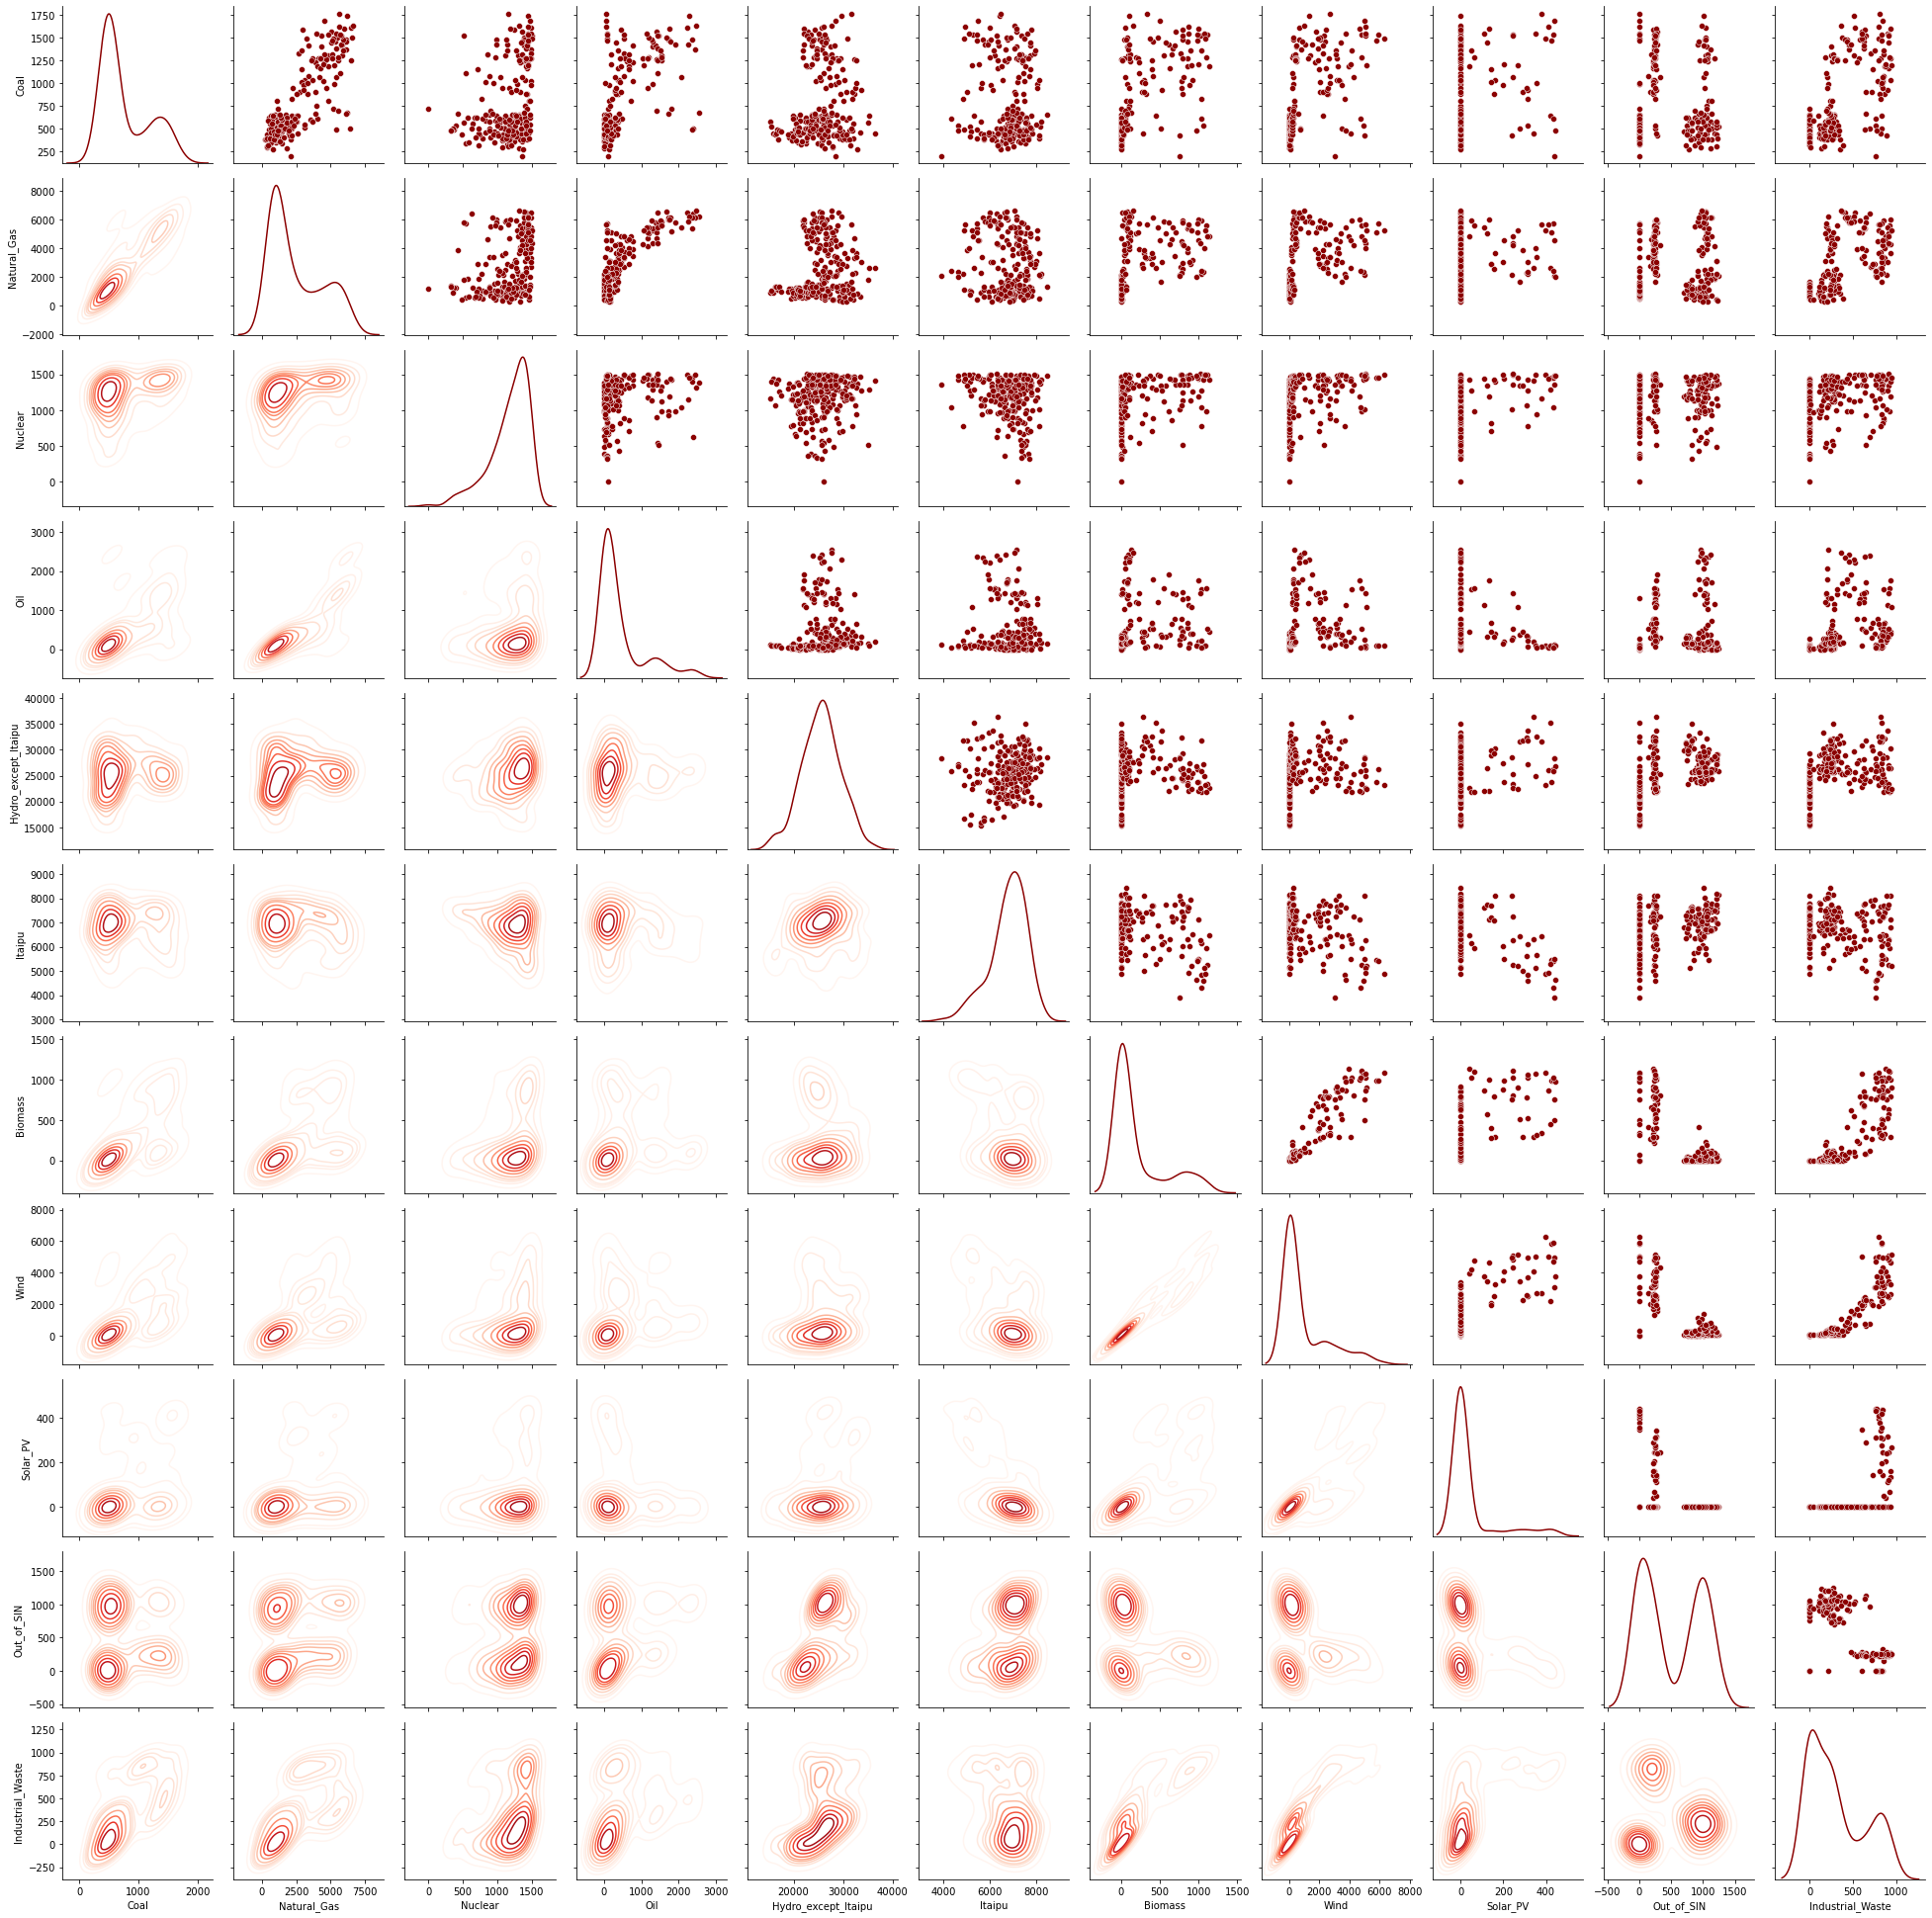

In [35]:
# Pair Grid for Electricity Sources
corr.pairgrid()

The Histograms of each variable have deviations from normality, except the variable "Hydroelectric plants (except Itaipu)" which has a very symmetrical distribution. Except for the Nuclear Source - which has Negative Asymmetry - all other variables have Positive Asymmetry. The scatter plots show that there isn't a substantial correlation between most of the variables.

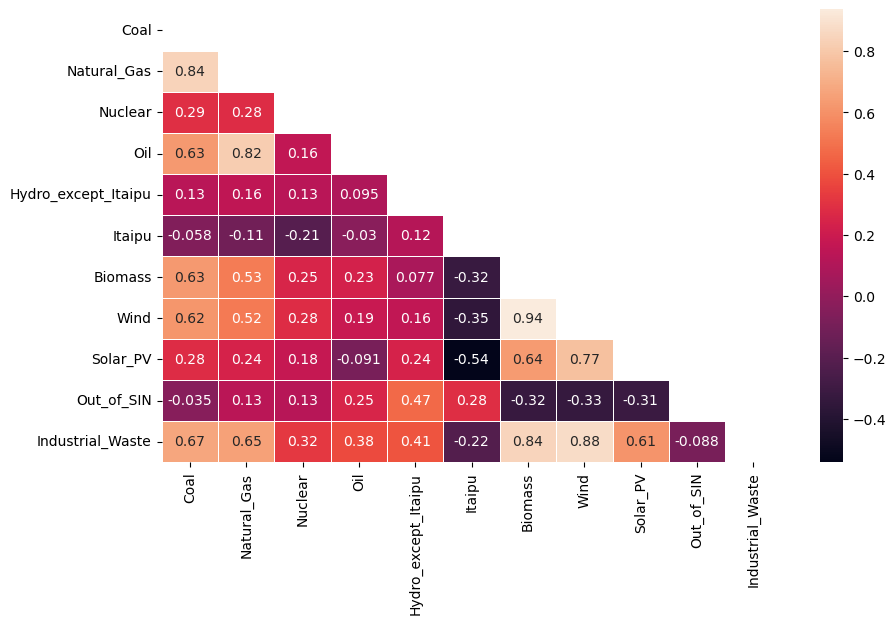

In [36]:
# Correlation between Electricity Sources
corr.heatmap()

The heat map above shows that most sources do not have strong correlations with each other, so that only five variables have correlation values ​​above 0.8, explained below:

In [37]:
# Selection of correlation values above 0.8
corr.select_corr(0.8, '>')

,Variable 1,Variable 2,Correlation
0,Biomass,Wind,0.936269
1,Wind,Industrial_Waste,0.877725
2,Biomass,Industrial_Waste,0.844093
3,Coal,Natural_Gas,0.843714
4,Natural_Gas,Oil,0.818324


There is a strong correlation between two Non-Renewable variables ("Natural Gas" with "Coal" and "Diesel Oil/Fuel"), and the highest correlation is seen between "Biomass" and "Wind" the only one being higher than 0.936. On the other hand, "Industrial Waste" which had recent growth, correlates very well with Biomass and Wind Power, which had the same trend. It is possible to infer causality since the sources have similar natures - Renewable or Non-Renewable - and their growth occurred at similar moments through government expansion policies.

In [38]:
# Selection of correlation values below -0.3
corr.select_corr(-0.3, '<')

,Variable 1,Variable 2,Correlation
0,Solar_PV,Out_of_SIN,-0.314258
1,Itaipu,Biomass,-0.321577
2,Biomass,Out_of_SIN,-0.323824
3,Wind,Out_of_SIN,-0.329168
4,Itaipu,Wind,-0.354621
5,Itaipu,Solar_PV,-0.541790


Among the values with negative correlation were selected variables with values below -0.3. Note that "Itaipu" and "Out_of_SIN" have negative correlations compared to "Biomass", "Wind" and "Solar_PV". As the behavior of "Out_of_SIN" is irregular, the focus will be on the correlation of "Itaipu" with renewable sources that have had growth in the recent Electricity Matrix, while "Itaipu" had a drop in its production due to the crisis in its Hydrographic Basin. Therefore, causality cannot be inferred between the strongest negative correlations seen in the dataset.

### 4.3. Exploration of the "Total" Variable

Creation of "Total" grouping objects referring to the "Stats" and "Charts" classes, in addition to the selection of variables belonging to the grouping.

In [39]:
# Creation of the object referring to the "Null" Class of "Total"
total_null = Null('Total', df_clean)

# Creation of the object referring to the "Stats" Class of "Total"
total_stats = Stats('Total', df_clean)

# Creation of the object referring to the "Charts" Class of "Total"
total_chart = Charts('Total', df_clean, sum, sum_perc)

# Selection of grouping variables
total_selection = df_clean[['Total', 'Hydro', 'Non_Renewable', 'Renewable_except_Hydro', 'Industrial_Waste', 'Out_of_SIN']]

In [40]:
total_null.null()

Series([], Name: Total, dtype: float64)

There are no null values ​​for this variable, as expected since it deals with the production of Total Energy.

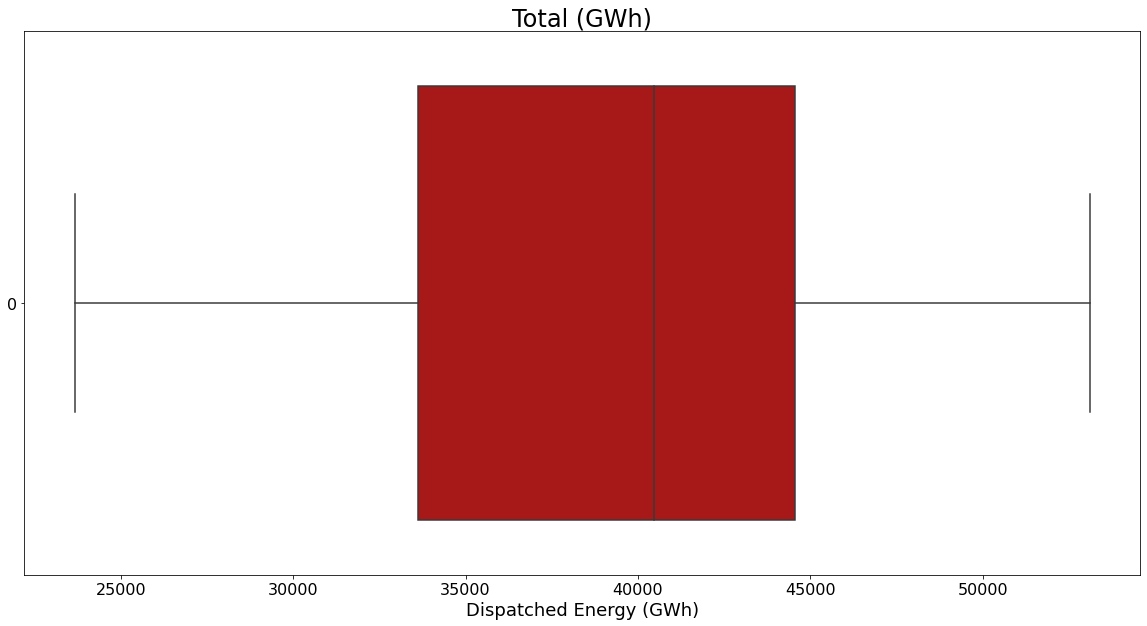

In [41]:
# Boxplot for Total Dispatched Energy
total_chart.boxplot()

In [42]:
# Statistical description for Total Dispatched Energy
total_stats.description()

,Total
count,239.000000
mean,39245.896169
std,6595.563042
min,23669.928370
25%,33605.637581
50%,40461.274022
75%,44554.007504
max,53103.613862


The boxplot does not show outliers, with the data concentrated in the range between the median and the third quartile (40641.27 GWh and 44554.01 GWh). The average Total Dispatched Energy in the dataset was 39245.90 GWh, with 23669.93 GWh as the minimum value and 53103.61 GWh as the maximum value.

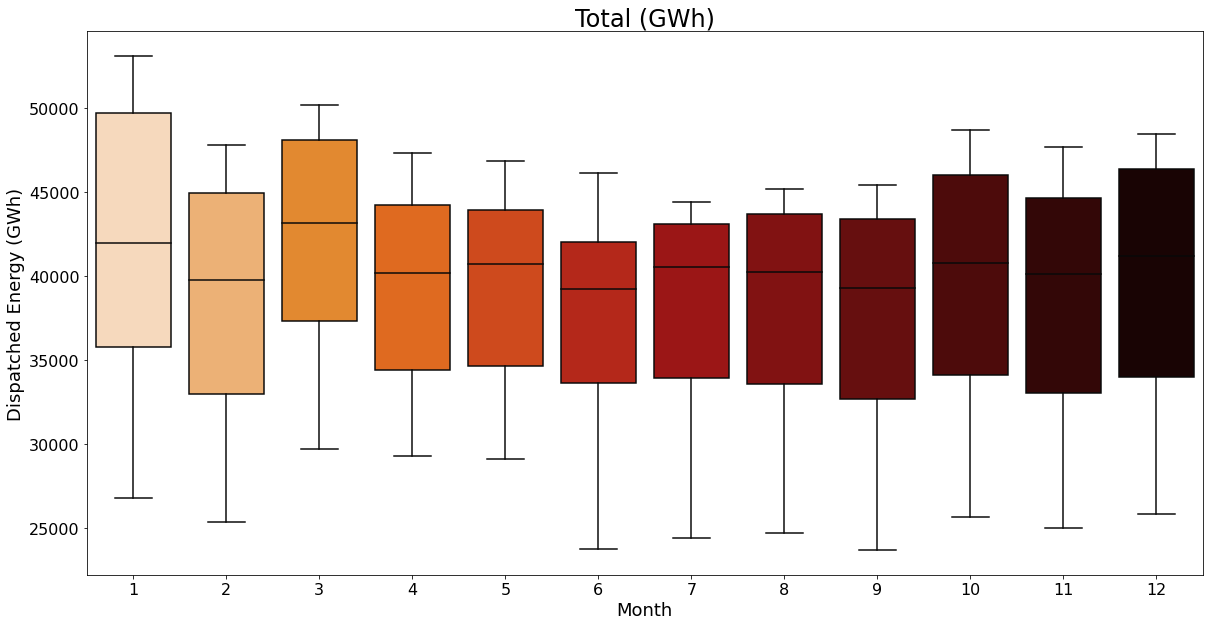

In [43]:
# Boxplot for monthly Total Dispatched Energy
total_chart.boxplot_monthly()

The boxplots referring to each month demonstrate the presence of seasonality in the data set since there is a clear difference in the behavior of the variable for different months. January and March concentrate the highest values ​​of energy dispatched while there is a drop between April and September, primarily in June.

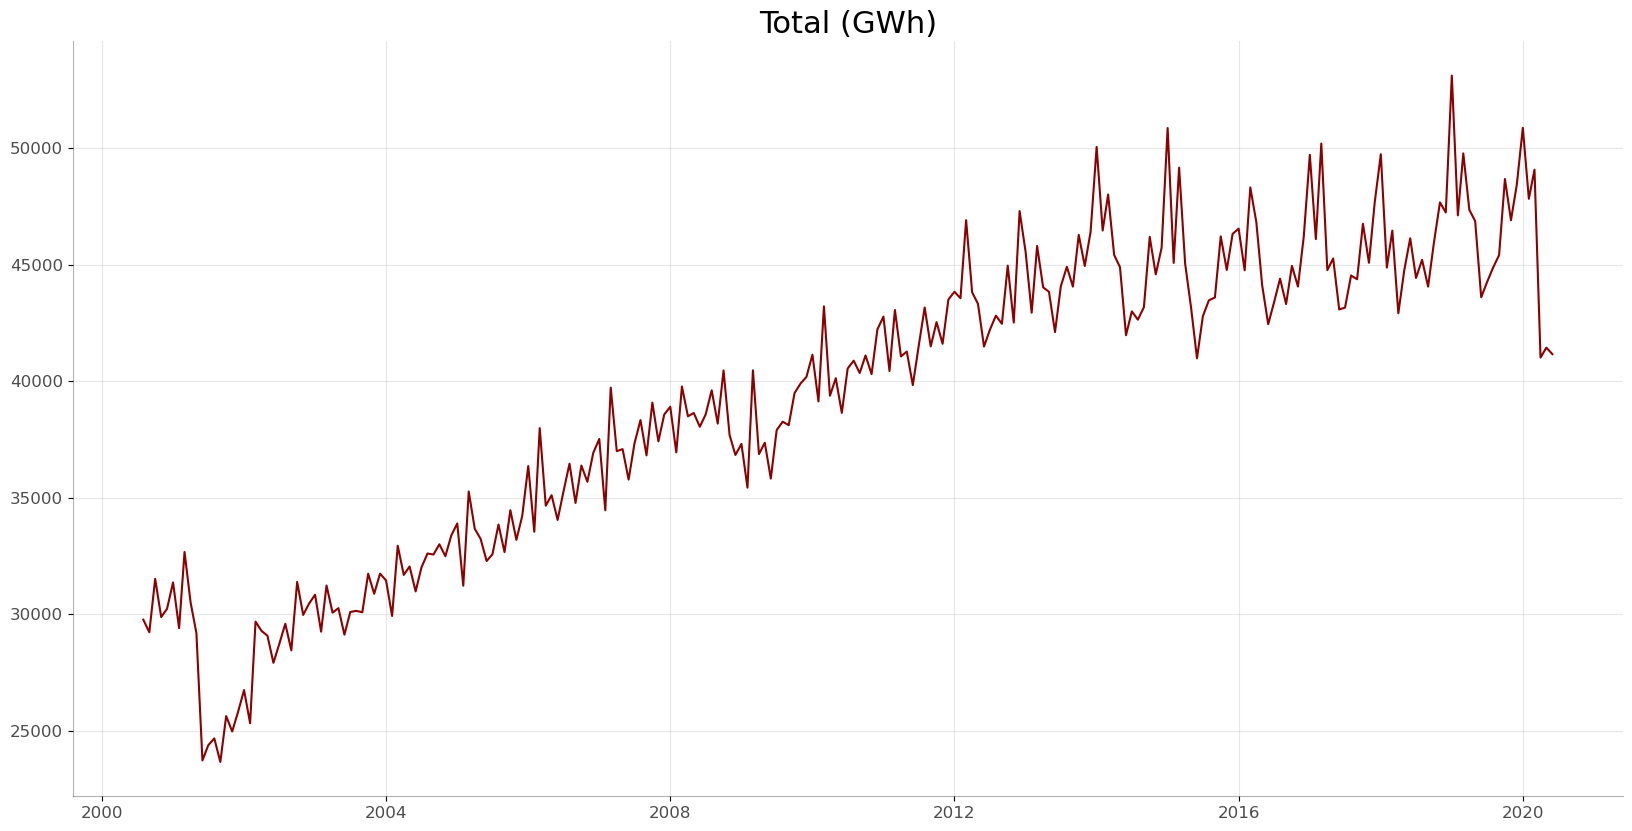

In [44]:
# Lineplot for Total Dispatched Energy
total_chart.lineplot()

There is a substantial drop at the beginning of 2001. Since then, there has been a gradual increase in Total Energy - except for the period between 2008 and 2009 - where the increasingly strong presence of seasonal factors in the Electric Matrix.

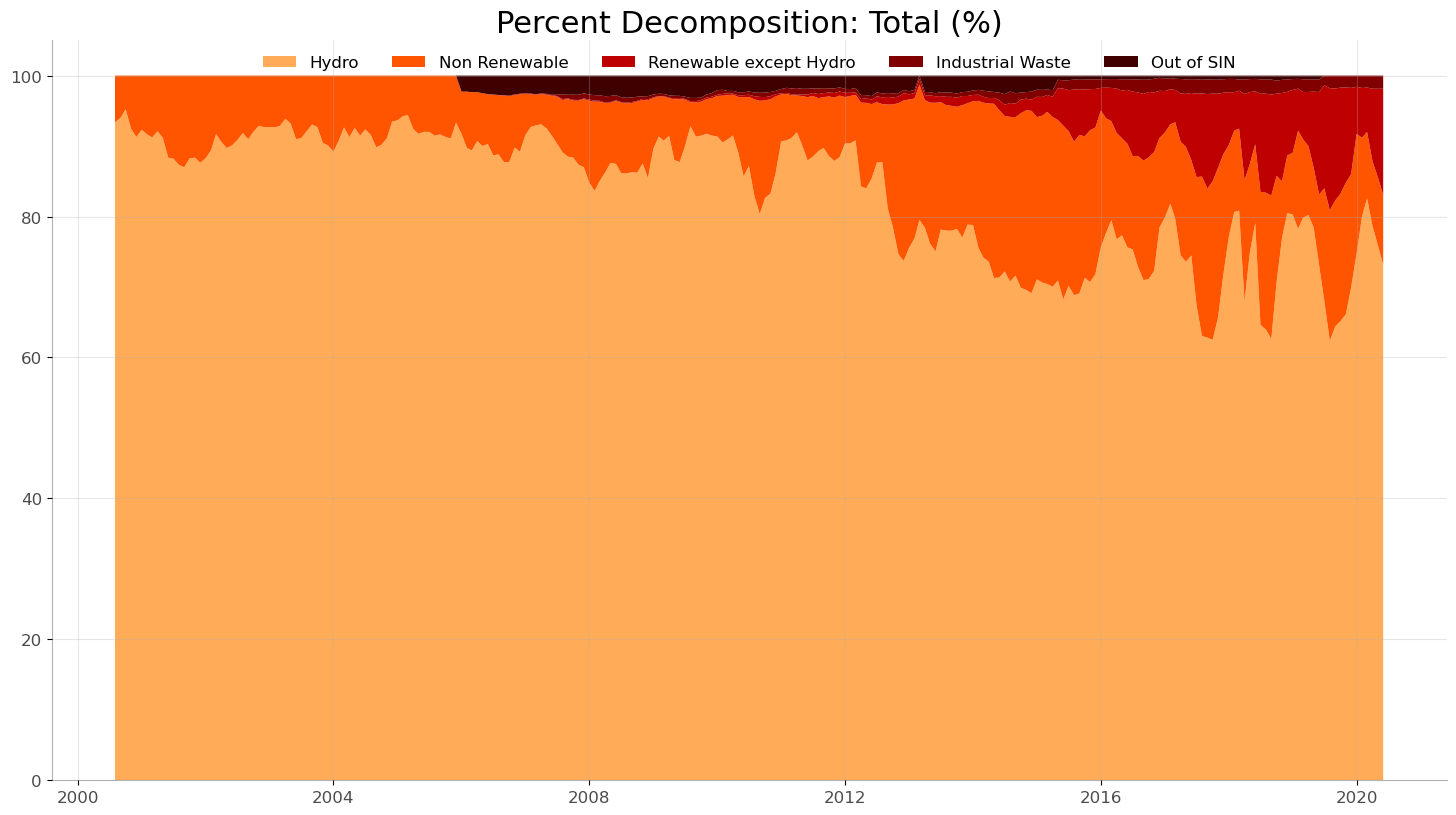

In [45]:
# Areaplot for Total Dispatched Energy
total_chart.areaplot(total_selection)

Until 2012, hydroelectric energy was strongly predominant in the Brazilian Electricity Matrix, reaching almost 90% of total electrical production at times. From this moment on, a relevant increase in Non-Renewable Sources can be seen until the middle of the decade, where a proportional increase in Renewable Sources (except Hydroelectric Power) can be seen, reaching almost 20% of the Total Dispatched Energy.

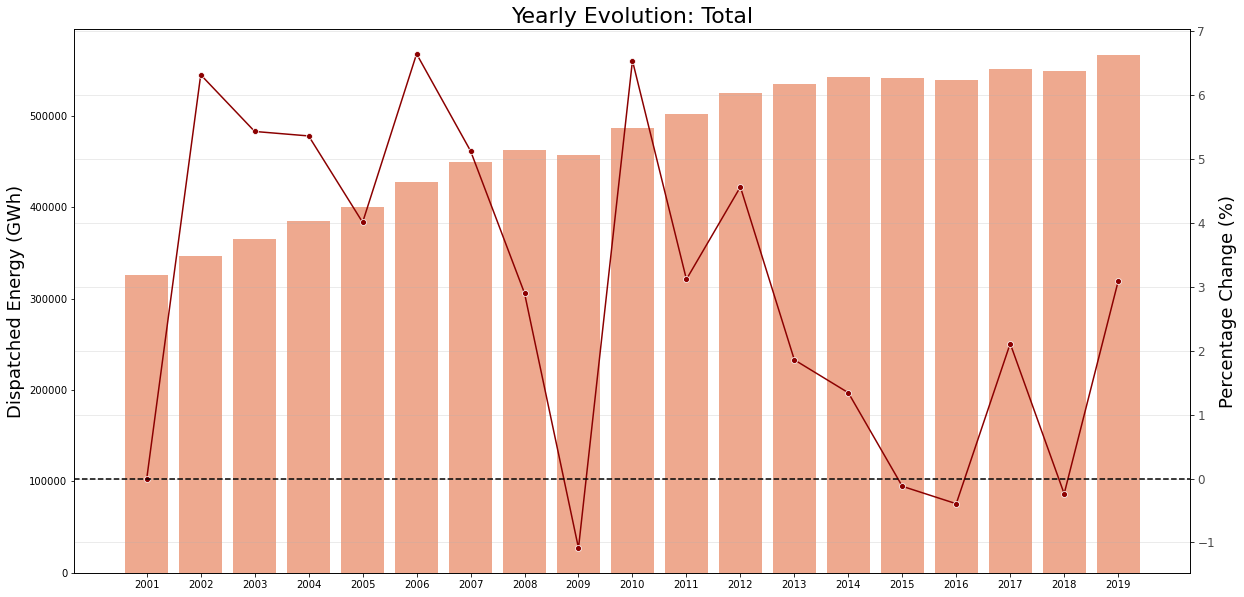

In [46]:
# Bar chart of Total Dispatched Energy together with a Line Chart indicating its annual percentage change
total_chart.mixedplot()

Total Dispatched Energy grew steadily from the beginning of the Historic Series to 2014, with 2009 being the only exception, influenced by the economic downturn generated by the World Crisis. However, in 2015 and 2016 there were declines as a result of an Internal Economic Crisis, which resulted in the growth of more than 2% in 2017 and of more than 3% in 2019, except for 2018, which saw a slight decline.

A relevant point of discussion for the history of the Brazilian Electricity Matrix is ​​to understand the period of drop in production observed between 2001 and 2002. When observing the area graph, it is noticed that in this period the Electric Matrix was strongly dominated by Hydroelectric plants, which had a share of over 90%. However, its share dropped significantly in this period, causing a sharp drop in total energy production.

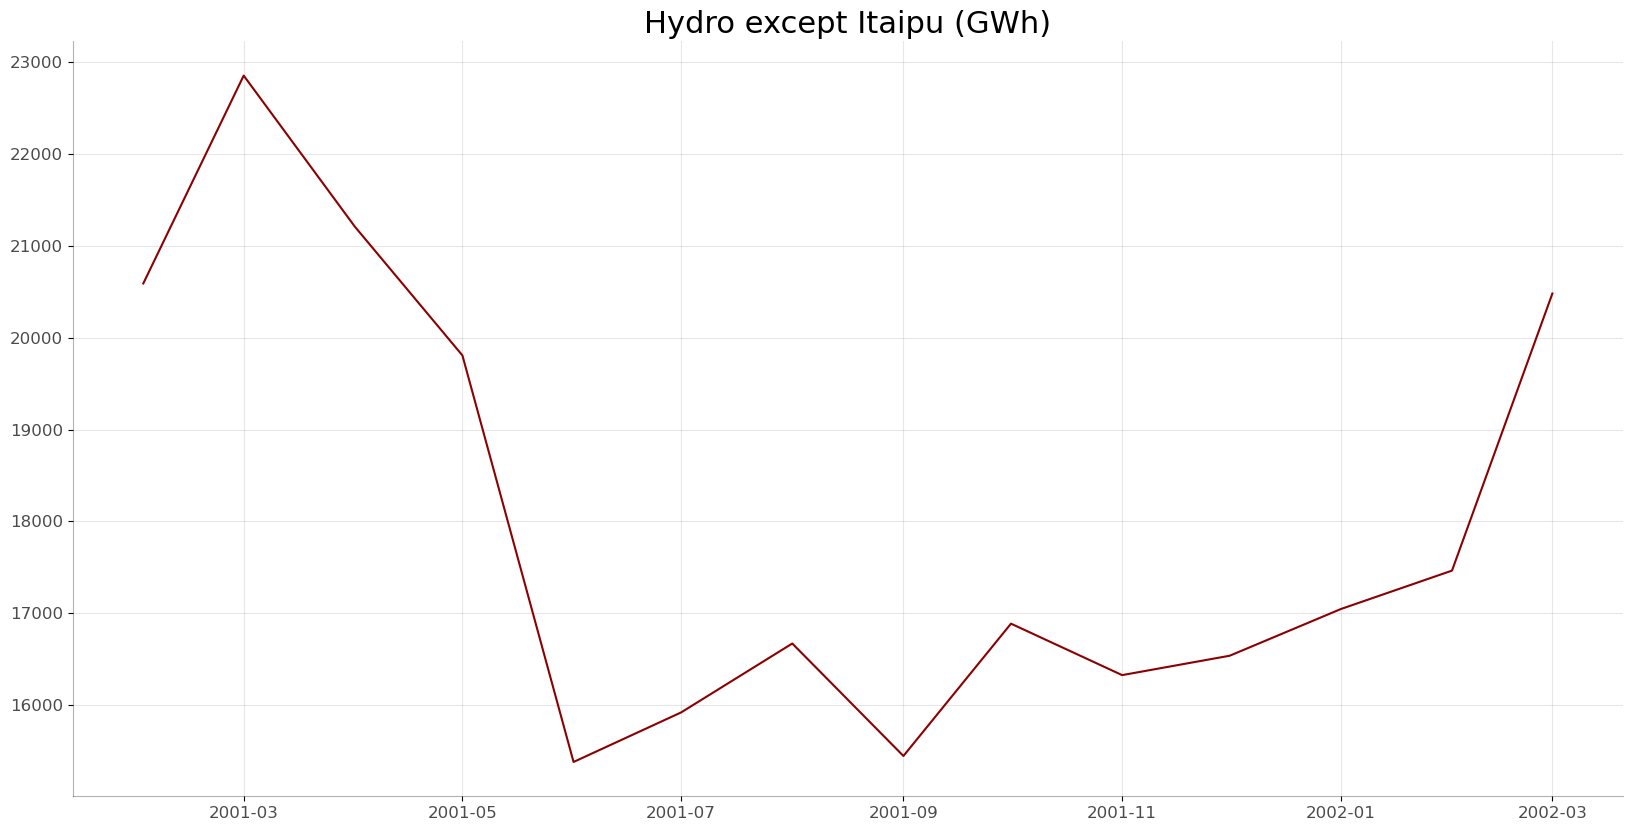

In [47]:
# Creation of the object referring to the "Graphics" Class of "Hydroelectricity (except Itaipu)"
hydro_except_itaipu_chart = Charts('Hydro_except_Itaipu', df_clean.loc['02-2001':'03-2002'], sum, sum_perc)

# Lineplot for the Hydroelectric Source (except Itaipu) between February 2001 and March 2002
hydro_except_itaipu_chart.lineplot()

There was a lack of supply hydroelectric energy during this period, causing the "Blackout crisis". Therefore, was adopted electrical energy rationing to avoid a collapse of the electrical system in the Southeast, Northeast, and Midwest regions, rewarding people who reduced their consumption and penalizing those who did not. Rationing was in effect between June 2001 and February 2002, which coincides with the data shown in the chart above.

For more details, access the
 [link](https://www.nexojornal.com.br/expresso/2021/05/31/Como-a-crise-atual-do-setor-el%C3%A9trico-se-compara-a-2001) (original text in Portuguese).

The main reason for the crisis was how the Brazilian Electricity Matrix failed to expand and diversify. There was a 49% increase in electricity consumption during the 1990s and an expansion of installed capacity by only 35%, which, together with below-average rainfall, resulted in the emptying of water reservoirs year after year. Consequently, this led to a substantial energy rationing, evidencing the problems of an energy matrix that is not very diversified and with expansion at a pace incompatible with the increase in consumption.

For more details about the problem experienced at the time, I recommend reading this article written by Mauricio Tolmasquim, which can be accessed through this [link](http://www.scielo.br/scielo.php?script=sci_arttext&pid=S1414-753X2000000100012&lng=pt&tlng=pt) (original text in Portuguese).

The reduction in hydroelectric production that occurred in the first half of the 2010s was due to another level drop in the hydroelectric reservoirs, compromising the production of hydroelectric energy. Therefore, Thermoelectric Power Plants were activated to avoid another rationing crisis, substantially increasing the use of Non-Renewable Sources. As a result, despite the guarantee of security in the energy supply, this increased the emission of greenhouse gases.

For more details, access the [Electric Energy Yearbook 2014
](https://www.epe.gov.br/sites-pt/publicacoes-dados-abertos/publicacoes/PublicacoesArquivos/publicacao-160/topico-168/Anu%C3%A1rio%20Estat%C3%ADstico%20de%20Energia%20El%C3%A9trica%202014.pdf) (original text in Portuguese), which analyzes data of 2013.

##### Renewable x Non-Renewable

As a complementary analysis, it is vital to know how the proportion of Renewable Energy dispatched in the SIN has changed compared to that coming from Non-Renewable Sources, excluding "Out of SIN" and "Industrial Waste". They will not be included in those groups because their participation in the matrix is not very significant, it's impossible to identify the nature of their sources, and the data is too irregular and far from reality in the case of "Out of SIN ".

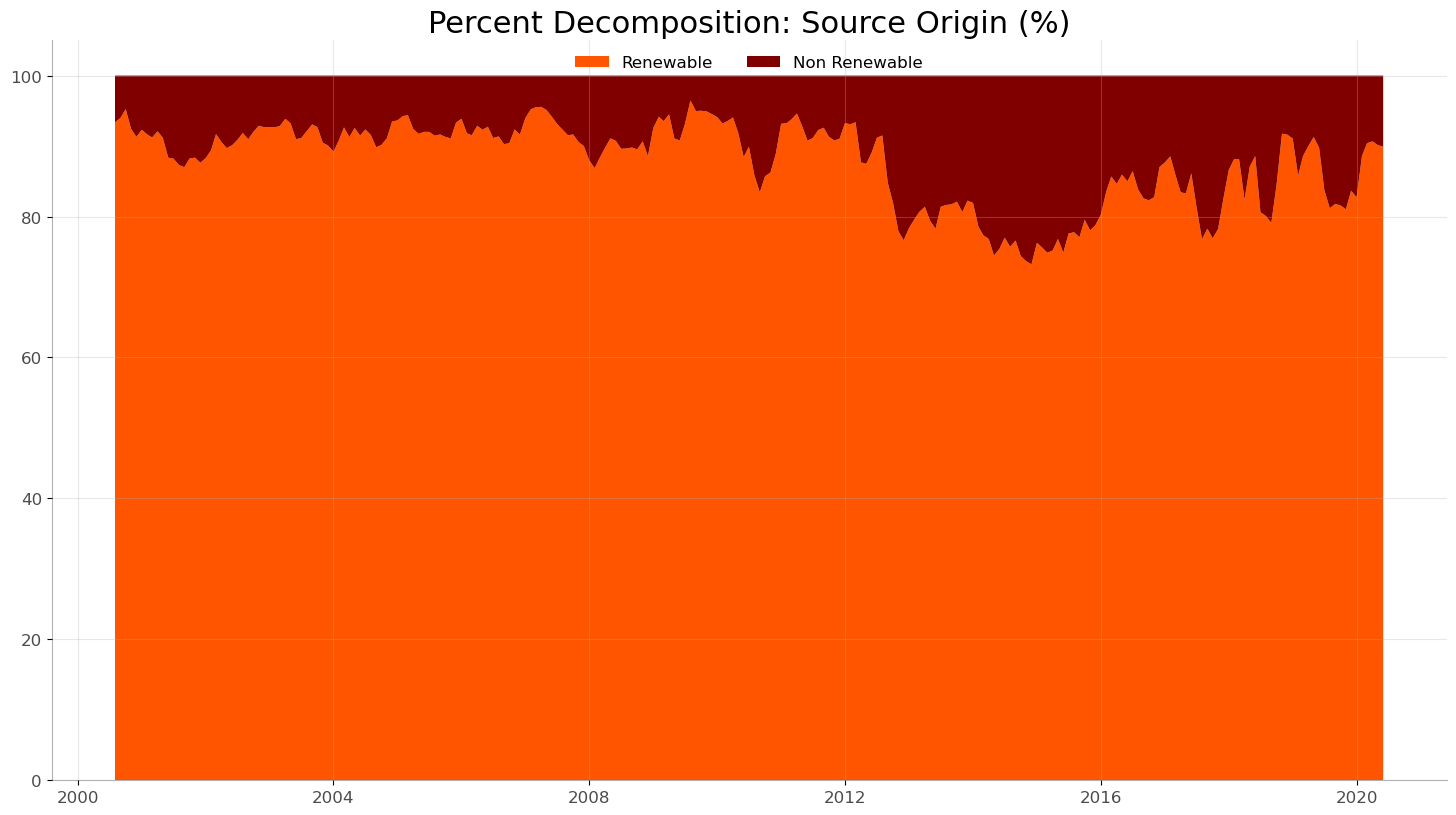

In [48]:
# Creation of the variable that sums Renewable and Non-Renewable Energy
origin = pd.DataFrame(df_clean['Total'] - df_clean['Industrial_Waste'] - df_clean['Out_of_SIN'], columns=['Source Origin'])
selection = df_clean[['Renewable', 'Non_Renewable']]
origin_df = pd.concat([origin, selection], axis=1)

# Creation of the object referring to the "Charts" Class of "Origin"
origin_chart = Charts('origin', selection, sum=None, sum_perc=None)

# Area Chart comparing Renewable and Non-Renewable Energy
origin_chart.areaplot(origin_df)

Brazil is internationally known for the strong predominance of Renewable Sources in its Electric Matrix, emphasizing the predominant use of hydroelectric plants. However, the strong dependence on this source generated problems in guaranteeing electricity supply in the 2001 Crisis, encouraging the construction of Thermoelectric Power Plants so that they could be activated in times of water crisis. However, the use of thermoelectric plants makes energy production more expensive and increases the emission levels of carbon dioxide (CO2), which contributes to the increase in global warming, causing problems from an economic, social, and environmental point of view. Therefore, the diversification of the Brazilian Electricity Matrix must be done in order to maximize the electric production in order to guarantee the security in the energy supply while minimizing the emission of greenhouse gases.


The graph above shows the share of Renewable Sources (which exceeded 90% in many moments) dropping to values ​​below 80% in the mid-2010s. However, since the end of the 2010s, there has been an increase in the use of Renewable Sources, approaching the level observed at the beginning of the century at its maximum points. Thus, it is important to observe the composition of Renewable Energy in Brazil through the 21st century.

In [49]:
renewable_selection

nomFonteGeracao,Hydro_except_Itaipu,Itaipu,Wind,Biomass,Solar_PV
date,,,,,
2000-01-01,21074.749841,6523.780292,0.00000,0.00000,NaN
2000-02-01,20519.823366,6362.831799,0.00000,0.00000,NaN
2000-03-01,21184.922627,7593.289824,0.00000,0.00000,NaN
2000-04-01,7128.300200,39.287100,0.00000,358.88560,NaN
2000-05-01,21986.323500,6814.969400,0.00000,0.00000,NaN
...,...,...,...,...,...
2020-02-01,32612.889600,5646.801120,2710.30752,309.88008,357.36816
2020-03-01,35229.709440,5294.795040,2215.23768,451.83864,419.48208
2020-04-01,28373.400000,3886.149600,3039.06240,759.34080,438.44400


In [50]:
# Creation of the object referring to the "Charts" Class of "Renewable"
renewable_chart = Charts('Renewable', df_clean, sum, sum_perc)

# Selection of grouping variables
renewable_selection = df_clean[['Renewable', 'Hydro_except_Itaipu', 'Itaipu', 'Wind', 'Biomass', 'Solar_PV']]

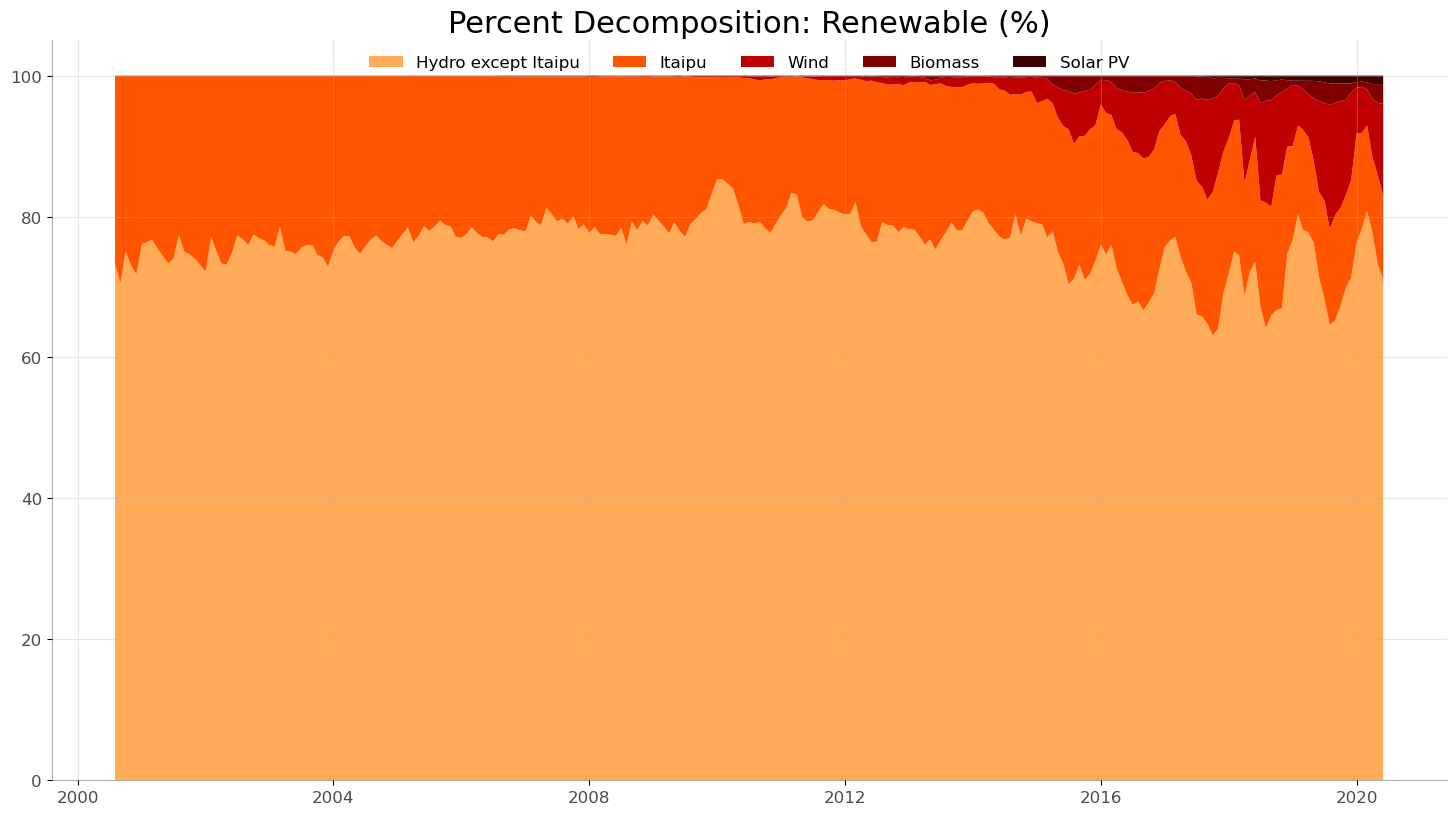

In [51]:
# Area Chart for "Renewable" Cluster
renewable_chart.areaplot(renewable_selection)

The Renewable group was only composed of Hydroelectric Sources in the 2000s, with other sources starting to participate in SIN at the beginning of the 2010s. At the end of the period, the predominance of Hydroelectric plants decreases, with the growth of the wind source highlighted. It is interesting to observe that the maximum points of wind production cause the participation of the other electrical sources to fall sharply in the group, so that "Hydroelectric plants (except Itaipu)" manages to obtain a share of just over 60% among Renewable Sources, demonstrating the recent diversification in the Electric Matrix.

Hence, this analysis demonstrated how the Brazilian Electricity Matrix developed and the main changes in its composition. After the increase of the diversification of the Electric Matrix and the decrease in the use of non-renewable sources, the new challenge is to accelerate the implementation of these sources in the matrix. However, it is essential to minimize the impact of these sources on the security of the energy supply since Wind and Solar Photovoltaic Sources are intermittent, which can lead to fluctuations in energy supply.

## 5. TIME SERIES ANALYSIS

A Time-Series can be decomposed into two parameters to facilitate its analysis: trend(trend) and seasonal(seasonality), where:
 - Trend: Indicates the behavior of the variable over time, perceiving the growth, fall, or stability of the series.
 - Seasonality: Evaluates the variations that occur in the same time cycle, which can be daily (24-hour cycle), weekly (7-day cycle), annual (12-month cycle), among others.

Therefore, a set of graphs will be plotted to evaluate these parameters for the Time Series, in addition to the residuals, which indicate the remaining value of the variable after the decomposition of the series into trend and seasonality.

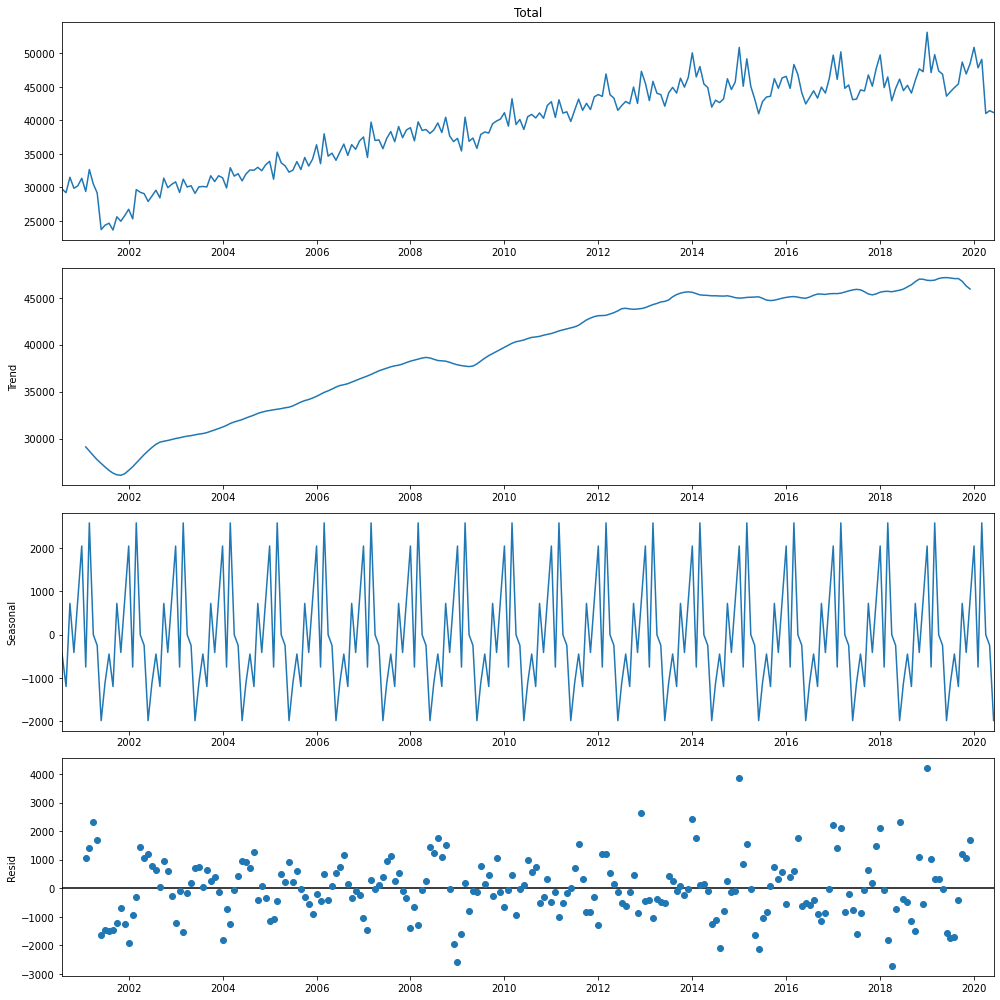

In [52]:
# Setting the object of class "Sarima" to "Total"
total_sarima = Sarima(df_clean, 'Total')

# Decomposition of the Time Series
total_sarima.seasonal_decompose()

The decomposition shows an upward trend until 2014, except for the period between 2001 and 2002 (Water Crisis and energy rationing) and 2009 (World Economic Crisis). From 2015 onwards, there is a trend towards stationarity, with slight variations. The seasonality shown by the graph coincides with that indicated by the monthly boxplot, with peaks in January and March and higher valleys in the middle of the year, especially in June. Residuals tend to remain close to zero, but there is a high level of dispersion, especially for the latest Time Series data.

### 5.1. Statistical Stationarity Tests

The Dickey-Fuller Augmented Test is a more complex version of the Dickey-Fuller test, aiming to determine the existence of a unit root in an autoregressive model. The presence of the unit root - represented by alpha (α) - implies that the series is non-stationary, where its presence is indicated from a null hypothesis test that assumes its existence. The statistic of this test is indicated by a negative value, which, the more negative it is, the greater the confidence in the rejection of the presented hypothesis. The result of a p-value less than 0.05 - indicating a significance of up to 5% - implies the rejection of the hypothesis that the series is non-stationary.


   | p-value | Hypothesis |
   |:------:|:------:|
   | p < 0.05 | H0: Non-stationary series |
   | p >= 0.05 | H1 : Stationary series |

The function representing this test is shown below.

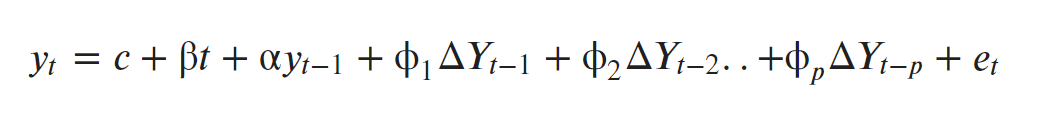

The Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test is similar to the ADF Test because it is also a unit root test, indicating whether the series has a stationary trend. However, unlike the ADF, the null hypothesis of the KPSS Test assumes the stationarity of the series, so a p < 0.05 indicates that the series has a stationary trend.

   | p-value | Hypothesis |
   |:------:|:------:|
   | p < 0.05 | H0: Series has a stationary trend |
   | p >= 0.05 | H1 : Series does not have a stationary trend |

In [53]:
# Performance of the ADF and KPSS Tests with no differentiation
total_sarima.adf_kpss(0)

,Energy Source,ADF,P-Valor ADF,Stationary ADF,KPSS,P-Valor KPSS,Stationary KPSS
0,Total,-2.287699,0.175966,False,2.127527,0.01,False


As both tests indicate that the series is not stationary, it will be necessary to perform at least one differentiation to make the series stationary.

In [54]:
# Performance of ADF and KPSS Tests with 1 (one) differentiation
total_sarima.adf_kpss(1)

,Energy Source,ADF,P-Valor ADF,Stationary ADF,KPSS,P-Valor KPSS,Stationary KPSS
0,Total,-5.804598,4.547433e-07,True,0.070501,0.1,True


Therefore, one differentiation is sufficient for the series to be stationary. The number of differentiations is a relevant parameter for the SARIMA model, which will be applied for modeling the series. This model and its parameters will be explained below.

### 5.2. SARIMA

The SARIMA model (Seasonal Auto-Regressive Integrated Moving Average) is a combination of different models for time series modeling, where:
 - AR: Refers to the Autoregressive Model, which uses old values ​​from the Time Series to create the predictive model;
 - MA: Refers to the Moving Average Model, which uses old residual values ​​to create the model;
 - I: Indicates the differentiation factor between the Time Series data;
 - S: Allows the inclusion of extra parameters to the ARIMA model to measure the impact of seasonality on the values ​​of the Time Series.

The SARIMA model includes extra parameters to the ARIMA model that allows the measurement of seasonality in the data. Thus, the model is structured in the form SARIMA(p,d,q)(P, Q, D, S), where:

 - p: Indicates the number of "lags" of the Autoregressive model;
 - d: Indicates the number of differentiation;
 - q: Indicates the number of lags of the Moving Averages model;
 - P: Seasonal Autoregression Order;
 - D: Order of seasonal differentiation;
 - Q: Seasonal Moving Average Order;
 - S: Size of the seasonality lag.

In this way, a SARIMA model will be created to predict the behavior of Total Energy in the next 12 months. To obtain the best set of parameters from this dataset, a "grid search" will be performed, where all possible combinations of SARIMA(p,d,q)(P, Q, D, S) parameters will be scanned. The best set will be chosen as the one that has the lowest AIC value (Akaike's information criterion), which measures the quality and simplicity of a statistical model.

As the statistical tests of stationarity indicated the need for only one differentiation, the parameters "d" and "D" will be set to 1. The parameters "p", "q", "P", and "Q" will have their values ranging from 0 to 4. As it is an annual model, the value of "S" will be fixed at 12.

The model will be trained on a training dataset that contains the first 197 values ​​of the dataset (August/2000 to December/2016) for later validation of the model with the remaining data.

In [55]:
# Best parameters for the SARIMA model
total_sarima.sarima_model()

Time taken to calculate the best parameters: 4069.79 seconds


,pdq,seasonal_pdq,aic
545,"(4, 1, 1)","(4, 1, 0, 12)",2217.027023


The SARIMA(4,1,1)(4,1,0,12) combination was the one that obtained the lowest AIC value among those that demonstrated a significantly valid result, eliminating combinations that had little AIC values ​​but returned results impossible to use. Note that it took 4069 seconds (more than 67 minutes) to run this program, demonstrating the high computational consumption required to perform a "grid search".

                                      SARIMAX Results                                      
Dep. Variable:                               Total   No. Observations:                  197
Model:             SARIMAX(4, 1, 1)x(4, 1, [], 12)   Log Likelihood               -1098.514
Date:                             Thu, 24 Mar 2022   AIC                           2217.027
Time:                                     01:02:12   BIC                           2245.855
Sample:                                 08-01-2000   HQIC                          2228.741
                                      - 12-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4490      0.112      4.011      0.000       0.230       0.668
ar.L2          0.1964      

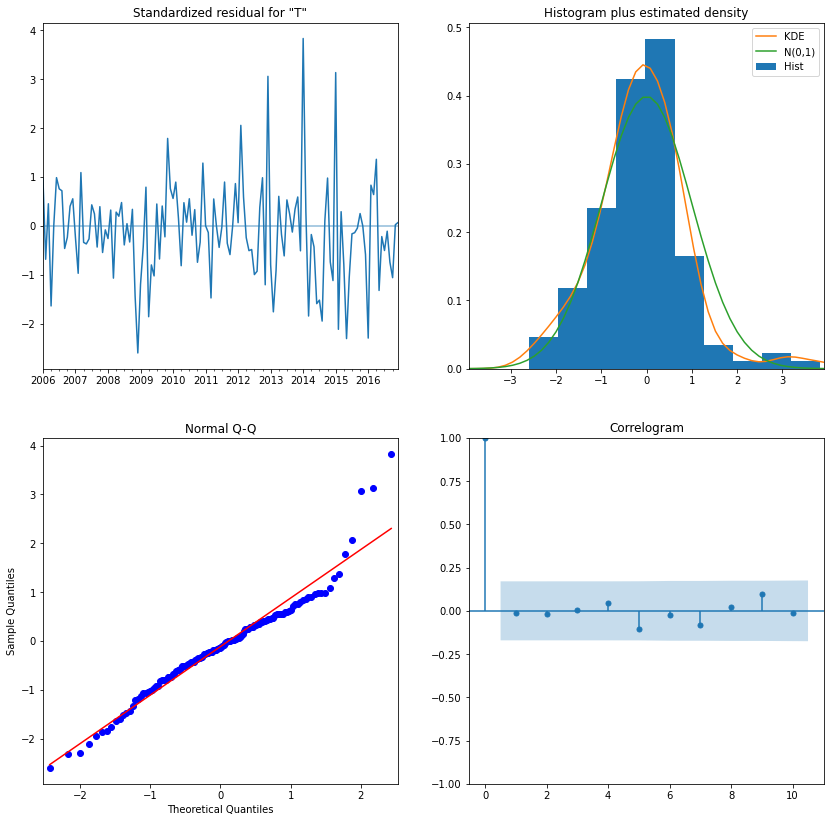

In [56]:
# Summary and diagnostic graphs of model results 
total_sarima.summary() 

The summary of the results notes that the Prob(Q) referring to the Ljung-Box Test is larger than 0.05, which shows that the residuals are not correlated, which is desirable. As the dataset has an input value lower than 2000, it is impossible to use the Jarque-Bera Test to assess whether the residual distribution resembles a normal one.

From the chart of "Standardized residual" (1,1) (standardized residuals), it can be seen that there is not a very well-established trend in its distribution, although there is a relevant amount of ridges and valleys.

The KDE Histogram of residuals (1,2) shows that its distribution resembles a normal distribution, although there is a certain distortion, mainly referring to the last data of the histogram, which shows a ridge that causes it to deviate from normal behavior.

The QQ Chart (2,1) reinforces this trend since the residuals behave normally until the final part of the data set, where there is a significant departure, demonstrated by the points far above the red line and the high number of points below the red line. 

The ACF Correlogram (ACF Plot) (2,2) shows that the "lags" are not significant, remaining within the blue area, which is what is desired.

In [57]:
# Model validation metrics
total_sarima.accuracy()

,Root Mean Square Error,Normalized Root Mean Square Error,Mean Absolute Percent Error (%)
model,1755.059955,0.145135,2.664028


The model validation measures with the best AIC show a relatively low REQM when considering the magnitude of the data, resulting in a Normalized REQM of 0.14. The EPAM was only 2.66%, which is a very satisfactory result.

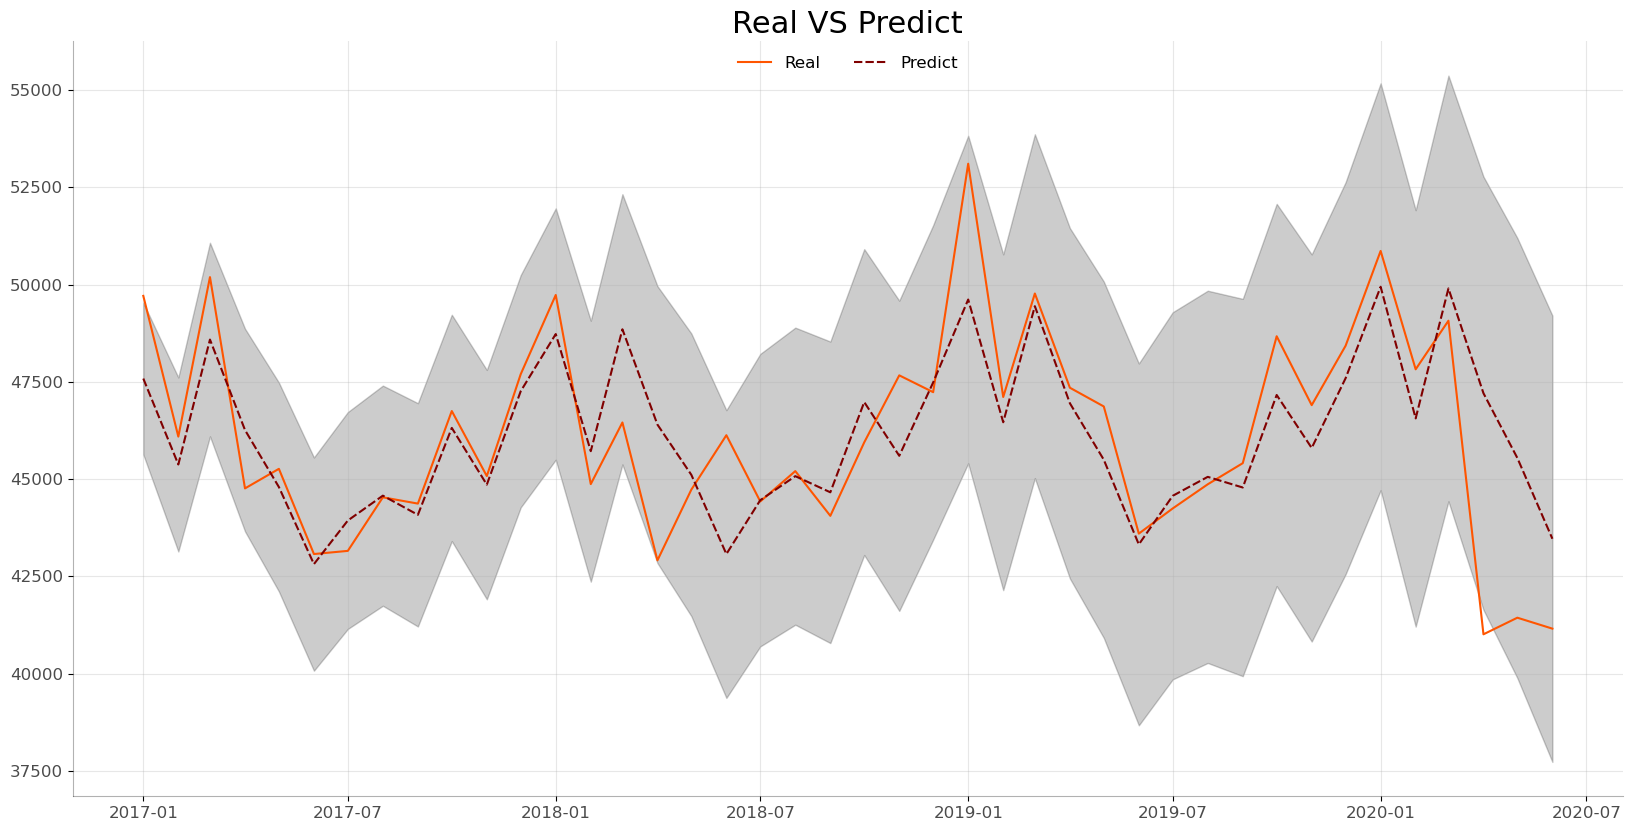

In [58]:
# Comparison chart between the test dataset (real) and the one predicted by the model
total_sarima.prediction_chart()

The graph above compares the data from the test dataset with those predicted by the calculated model. As the validation measures demonstrated, the model behaves very satisfactorily predicting results that it has never seen, since only one of the results "fled" from the 95% confidence interval, which is data that obtained an abnormally low behavior for the period. Therefore, the results above confirm the predictive capacity of the model. Now it will be used to forecast the next 12 months of Total Energy with the entire Historical Series and the confidence interval for the forecast.

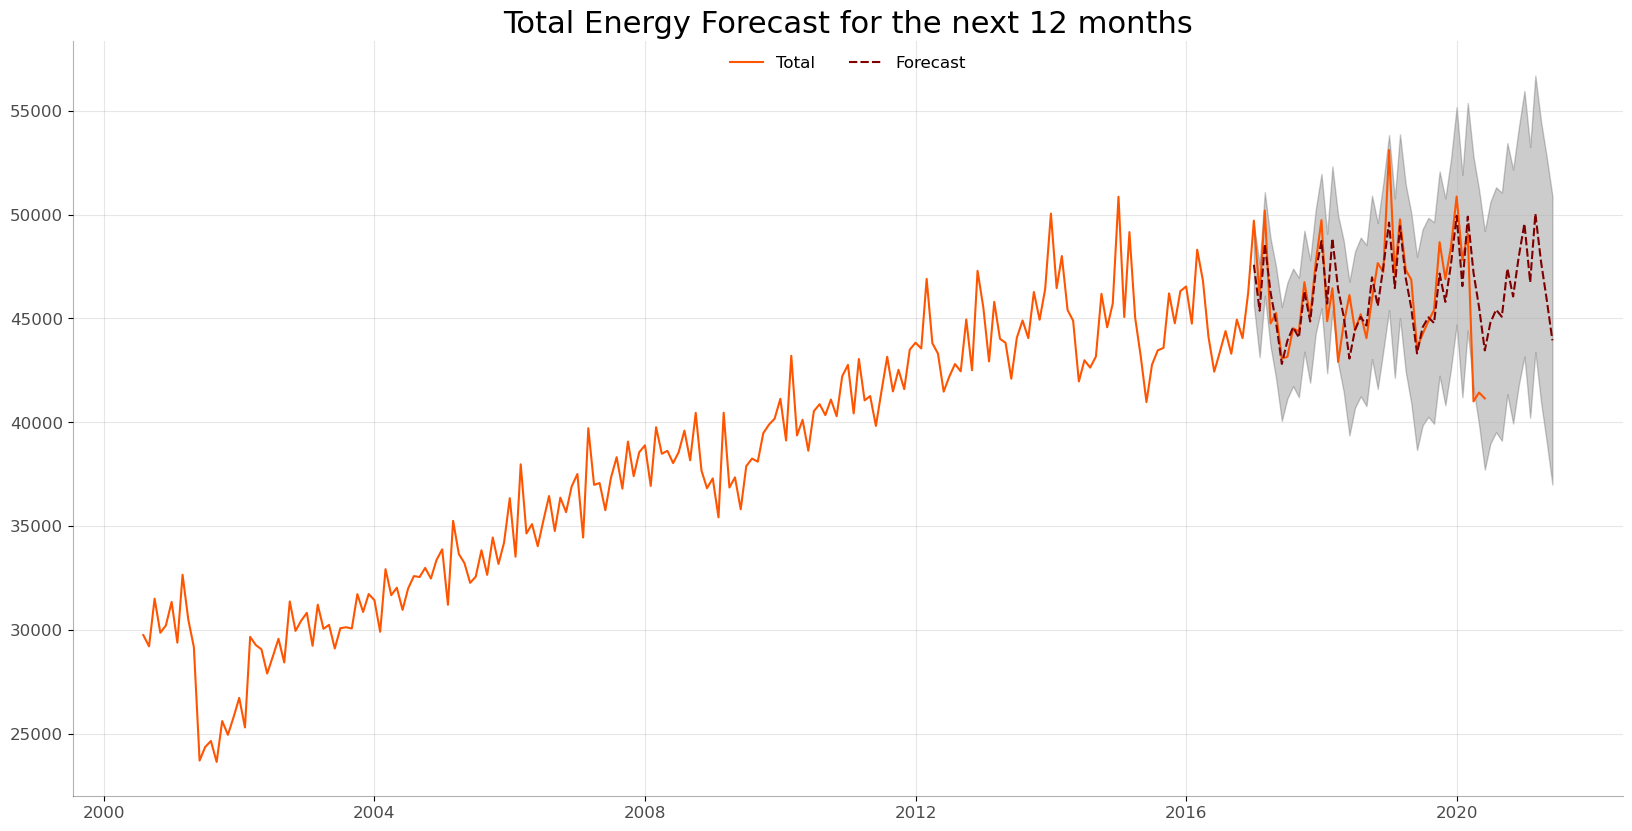

In [59]:
# Total Energy behavior forecast for the subsequent 12 months
total_sarima.forecast_chart()

# CONCLUSION 

Thus, the Analysis of Brazilian Electricity between 2000 and 2020 was concluded. In this project:
- Data was obtained through the Open Data provided by the Federal Government, its treatment and manipulation, which facilitated the subsequent analysis.
- The reasons that caused the behavior of the different variables in the Exploratory Data Analysis were discussed, showing the impact of government policies and environmental and economic crises on energy production.
- It concluded that Brazilian Electricity saw an expansion in the use of Renewable Energies that are not of water origin, which minimizes greenhouse gas emissions and reduces the effect that a water crisis can cause in the supply of energy to the population. However, this policy can generate impacts due to the increase in the use of intermittent sources in the Electric Matrix;
- An analysis of the Time Series of Total Dispatched Energy was made, decomposing its components and a predictive model was created for its behavior in the next 12 months.

If you want to ask me something, make any suggestions or talk about the project, contact me through my  [LinkedIn](https://www.linkedin.com/in/luanrdutra/). Also, come to see what I've been doing on my  [GitHub](https://github.com/LuanRD).

Thanks for your attention :D